# Learning the Inverse Discrete Fourier Transform

The Inverse Discrete Fourier Transform (IDFT) is used for reconstructing images acquired in k-space (Fourier domain). In this tutorial, we will show that the IDFT is equivalent to the logistic regression classifier and the logistic regression parameters (i.e. the IDFT coefficients) can be learned.

The goals of this tutorial are:
  - Illustrate how to do the IDFT and the logistic regression classifier are equivalents.
  - Illustrate that we can learn the IDFT coefficients.

In [1]:
%matplotlib inline
import matplotlib
matplotlib.rc('xtick', labelsize=4) 
matplotlib.rc('ytick', labelsize=4) 
import matplotlib.pylab as plt
import numpy as np
import os

import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers.noise import GaussianNoise
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import sys

MY_UTILS_PATH = '../Modules/'
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import ipt_utils 
np.random.seed(302)


Bad key "ckend" on line 1 in
/Users/robertosouza/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/Users/robertosouza/Documents/virtualenv/venv03/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Loading 1D Signals

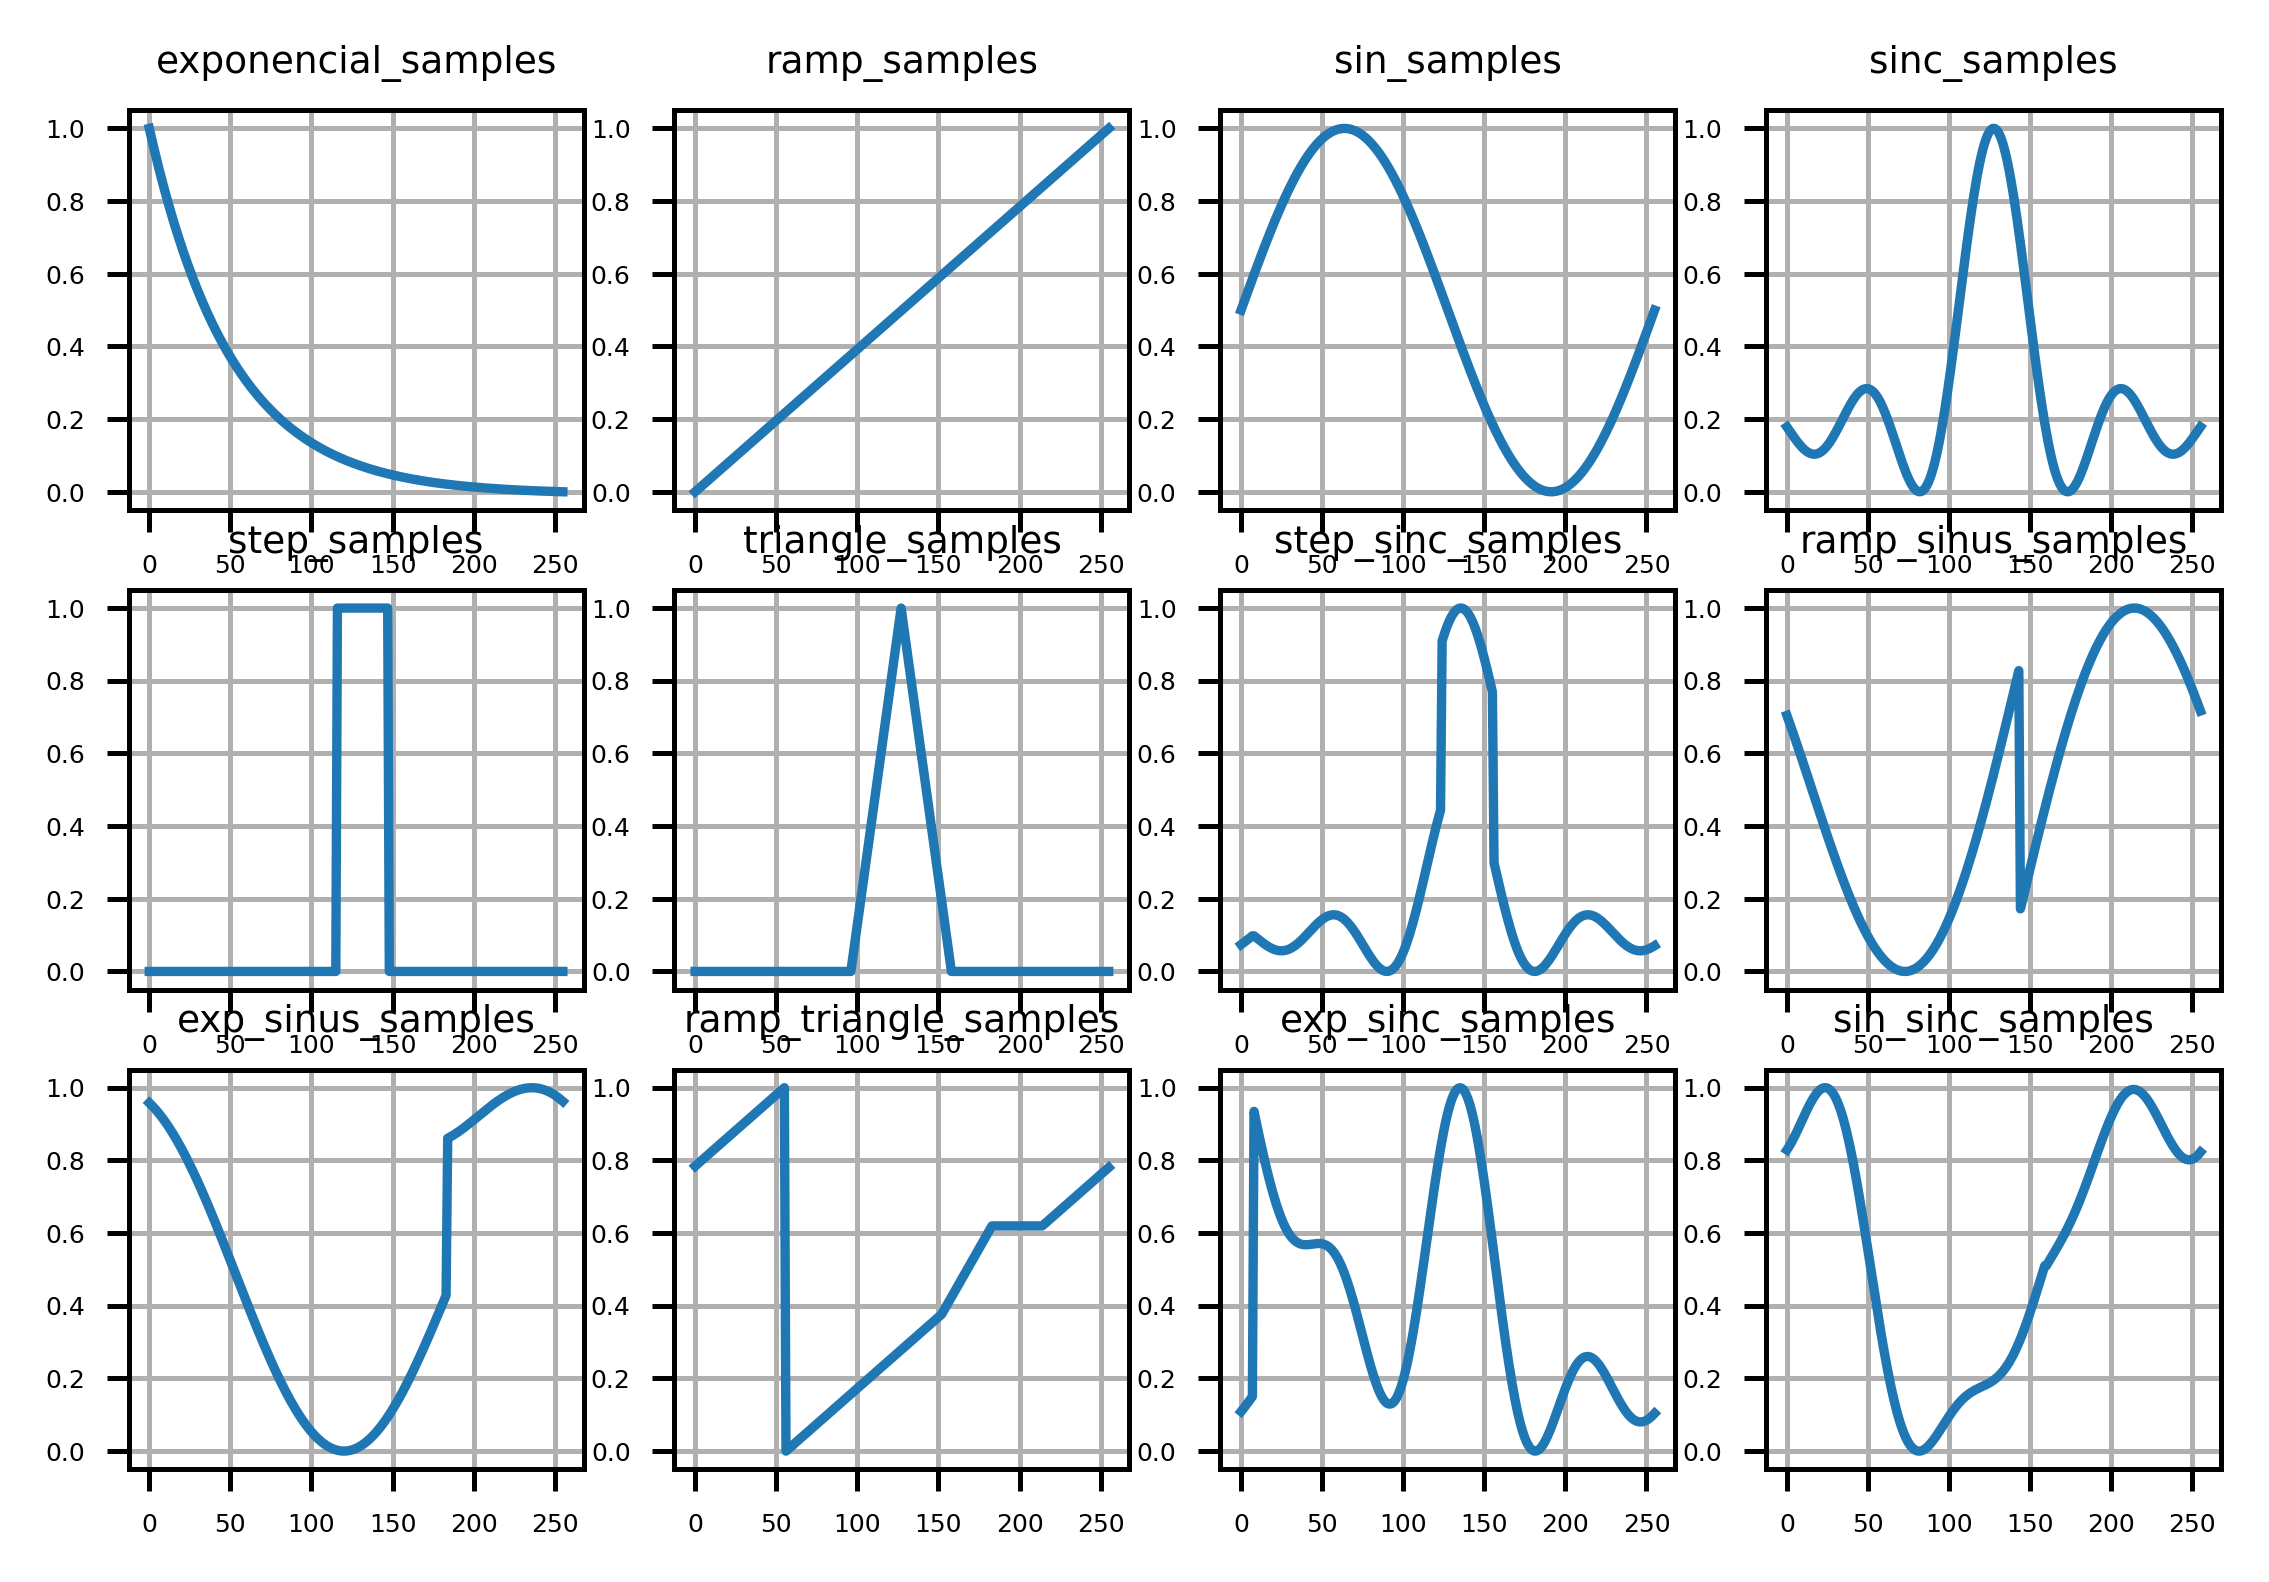

(360, 256)


In [5]:
signals_list = ["exponencial_samples.npy","ramp_samples.npy",\
                "sin_samples.npy","sinc_samples.npy","step_samples.npy",\
                "triangle_samples.npy","step_sinc_samples.npy",\
                "ramp_sinus_samples.npy","exp_sinus_samples.npy",\
                "ramp_triangle_samples.npy","exp_sinc_samples.npy","sin_sinc_samples.npy"]

signals_folder = "../Data"

shifts = 30
signals = np.zeros((len(signals_list)*shifts,256), dtype = np.float64)

# Loading data
for (ii,signal_file) in enumerate(signals_list):
    signals[ii*shifts:(ii+1)*shifts,:] = np.load(os.path.join(signals_folder,signal_file))
    

#Normalizing data between 0 and 1    
signals = (signals-signals.min(axis=1,keepdims = True))/\
          (signals.max(axis=1,keepdims = True)- signals.min(axis=1,keepdims = True))

fig, ax = plt.subplots(nrows=3, ncols=4,figsize = (6,4), dpi = 450)
counter = 0
for row in ax:
    for col in row:
        col.plot(signals[counter*shifts])
        col.grid()
        col.set_title(signals_list[counter].split(".")[0], fontsize = 6)
        counter+=1
plt.show()

print signals.shape

## Computing the Discrete Fourier Transform

In [7]:
fft_signals = np.fft.fft(signals)

#Shuffling samples
indexes = np.arange(signals.shape[0],dtype = int)
np.random.shuffle(indexes)
signals = signals[indexes]
fft_signals = fft_signals[indexes]

# Splitting into train and test sets
test_split = int(0.2*signals.shape[0])
signals_train = signals[:-test_split]
signals_test = signals[-test_split:]
fft_signals_train = fft_signals[:-test_split]
fft_signals_test = fft_signals[-test_split:]

#Splitting real and imaginary part and normalizing by the absolute value
# Train set
max_term = np.maximum(np.abs(fft_signals_train.real).max(),\
           np.abs(fft_signals_train.imag).max())           
fft_signals_train_split = np.zeros((fft_signals_train.shape[0],2*fft_signals_train.shape[1]))
fft_signals_train_split[:,:fft_signals_train.shape[1]] = fft_signals_train.real/max_term
fft_signals_train_split[:,fft_signals_train.shape[1]:] = fft_signals_train.imag/max_term

# Test
fft_signals_test_split = np.zeros((fft_signals_test.shape[0],2*fft_signals_test.shape[1]))
fft_signals_test_split[:,:fft_signals_test.shape[1]] = fft_signals_test.real/max_term
fft_signals_test_split[:,fft_signals_test.shape[1]:] = fft_signals_test.imag/max_term

## Defining the Logistic Regression Classifier to Compute the IDFT

In [8]:
def inverse_ft_model(learning_rate = 1e-3, learning_decay = 1e-8):
    inputs = Input(shape=(512,))
    out1 = Dense(256, activation='linear')(inputs)
    model = Model(inputs=inputs, outputs=out1)
    opt = Adam(lr=learning_rate, decay = learning_decay)
    model.compile(optimizer= opt,loss='mean_squared_error', metrics=['mean_squared_error'])
    return model

## Training the Model

In [12]:
# Early stopping callback to shut down training after 
# 10 epochs with no improvement
earlyStopping = EarlyStopping(monitor='mean_squared_error',
                                        patience=10, 
                                        verbose=1, mode='min')
# Checkpoint callback to save model after each improvement along the epochs
checkpoint = ModelCheckpoint('inverse_ft.hdf5', mode = 'min', monitor='mean_squared_error'
                            ,verbose=0, save_best_only=True, save_weights_only = True)

model = inverse_ft_model(learning_rate = 1e-2, learning_decay = 0) 
print signals_train.shape
print signals_train.dtype
print fft_signals_train_split.shape
print fft_signals_train_split.dtype
hist = model.fit(fft_signals_train_split,signals_train,epochs=5000,
                 batch_size=128,verbose=1,
                 validation_split=0.25,
                 shuffle = True,
                 callbacks=[checkpoint,earlyStopping])   

(288, 256)
float64
(288, 512)
float64
Train on 216 samples, validate on 72 samples
Epoch 1/5000
216/216 [==============================] - 0s 1ms/step - loss: 0.2427 - mean_squared_error: 0.2427 - val_loss: 0.2357 - val_mean_squared_error: 0.2357
Epoch 2/5000
216/216 [==============================] - 0s 70us/step - loss: 0.2109 - mean_squared_error: 0.2109 - val_loss: 0.2050 - val_mean_squared_error: 0.2050
Epoch 3/5000
216/216 [==============================] - 0s 75us/step - loss: 0.1825 - mean_squared_error: 0.1825 - val_loss: 0.1772 - val_mean_squared_error: 0.1772
Epoch 4/5000
216/216 [==============================] - 0s 74us/step - loss: 0.1559 - mean_squared_error: 0.1559 - val_loss: 0.1523 - val_mean_squared_error: 0.1523
Epoch 5/5000
216/216 [==============================] - 0s 72us/step - loss: 0.1329 - mean_squared_error: 0.1329 - val_loss: 0.1301 - val_mean_squared_error: 0.1301
Epoch 6/5000
216/216 [==============================] - 0s 76us/step - loss: 0.1124 - mean_sq

Epoch 50/5000
216/216 [==============================] - 0s 71us/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0068 - val_mean_squared_error: 0.0068
Epoch 51/5000
216/216 [==============================] - 0s 64us/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 52/5000
216/216 [==============================] - 0s 73us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 53/5000
216/216 [==============================] - 0s 69us/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 54/5000
216/216 [==============================] - 0s 72us/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0063 - val_mean_squared_error: 0.0063
Epoch 55/5000
216/216 [==============================] - 0s 70us/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0061 - val_mean_squared_error: 0.0061
Epoc

216/216 [==============================] - 0s 76us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 100/5000
216/216 [==============================] - 0s 67us/step - loss: 0.0010 - mean_squared_error: 0.0010 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 101/5000
216/216 [==============================] - 0s 65us/step - loss: 9.8663e-04 - mean_squared_error: 9.8663e-04 - val_loss: 0.0027 - val_mean_squared_error: 0.0027
Epoch 102/5000
216/216 [==============================] - 0s 89us/step - loss: 9.6175e-04 - mean_squared_error: 9.6175e-04 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 103/5000
216/216 [==============================] - 0s 72us/step - loss: 9.3898e-04 - mean_squared_error: 9.3898e-04 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 104/5000
216/216 [==============================] - 0s 69us/step - loss: 9.1498e-04 - mean_squared_error: 9.1498e-04 - val_loss: 0.0025 - val_mean_squ

216/216 [==============================] - 0s 64us/step - loss: 3.5180e-04 - mean_squared_error: 3.5180e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 146/5000
216/216 [==============================] - 0s 65us/step - loss: 3.4453e-04 - mean_squared_error: 3.4453e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 147/5000
216/216 [==============================] - 0s 73us/step - loss: 3.3715e-04 - mean_squared_error: 3.3715e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 148/5000
216/216 [==============================] - 0s 67us/step - loss: 3.3008e-04 - mean_squared_error: 3.3008e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 149/5000
216/216 [==============================] - 0s 66us/step - loss: 3.2345e-04 - mean_squared_error: 3.2345e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 150/5000
216/216 [==============================] - 0s 71us/step - loss: 3.1658e-04 - mean_squared_error: 3.1658e-04 - val_loss: 0.001

216/216 [==============================] - 0s 64us/step - loss: 1.4777e-04 - mean_squared_error: 1.4777e-04 - val_loss: 6.8843e-04 - val_mean_squared_error: 6.8843e-04
Epoch 191/5000
216/216 [==============================] - 0s 64us/step - loss: 1.4513e-04 - mean_squared_error: 1.4513e-04 - val_loss: 6.8022e-04 - val_mean_squared_error: 6.8022e-04
Epoch 192/5000
216/216 [==============================] - 0s 71us/step - loss: 1.4287e-04 - mean_squared_error: 1.4287e-04 - val_loss: 6.7139e-04 - val_mean_squared_error: 6.7139e-04
Epoch 193/5000
216/216 [==============================] - 0s 82us/step - loss: 1.4022e-04 - mean_squared_error: 1.4022e-04 - val_loss: 6.6315e-04 - val_mean_squared_error: 6.6315e-04
Epoch 194/5000
216/216 [==============================] - 0s 67us/step - loss: 1.3796e-04 - mean_squared_error: 1.3796e-04 - val_loss: 6.5461e-04 - val_mean_squared_error: 6.5461e-04
Epoch 195/5000
216/216 [==============================] - 0s 64us/step - loss: 1.3568e-04 - mean_squ

Epoch 235/5000
216/216 [==============================] - 0s 64us/step - loss: 7.3317e-05 - mean_squared_error: 7.3317e-05 - val_loss: 4.0917e-04 - val_mean_squared_error: 4.0917e-04
Epoch 236/5000
216/216 [==============================] - 0s 66us/step - loss: 7.2312e-05 - mean_squared_error: 7.2312e-05 - val_loss: 4.0494e-04 - val_mean_squared_error: 4.0494e-04
Epoch 237/5000
216/216 [==============================] - 0s 79us/step - loss: 7.1343e-05 - mean_squared_error: 7.1343e-05 - val_loss: 4.0066e-04 - val_mean_squared_error: 4.0066e-04
Epoch 238/5000
216/216 [==============================] - 0s 82us/step - loss: 7.0347e-05 - mean_squared_error: 7.0347e-05 - val_loss: 3.9654e-04 - val_mean_squared_error: 3.9654e-04
Epoch 239/5000
216/216 [==============================] - 0s 66us/step - loss: 6.9423e-05 - mean_squared_error: 6.9423e-05 - val_loss: 3.9253e-04 - val_mean_squared_error: 3.9253e-04
Epoch 240/5000
216/216 [==============================] - 0s 69us/step - loss: 6.8481

216/216 [==============================] - 0s 66us/step - loss: 4.2013e-05 - mean_squared_error: 4.2013e-05 - val_loss: 2.6711e-04 - val_mean_squared_error: 2.6711e-04
Epoch 280/5000
216/216 [==============================] - 0s 65us/step - loss: 4.1580e-05 - mean_squared_error: 4.1580e-05 - val_loss: 2.6471e-04 - val_mean_squared_error: 2.6471e-04
Epoch 281/5000
216/216 [==============================] - 0s 76us/step - loss: 4.1069e-05 - mean_squared_error: 4.1069e-05 - val_loss: 2.6249e-04 - val_mean_squared_error: 2.6249e-04
Epoch 282/5000
216/216 [==============================] - 0s 75us/step - loss: 4.0641e-05 - mean_squared_error: 4.0641e-05 - val_loss: 2.6018e-04 - val_mean_squared_error: 2.6018e-04
Epoch 283/5000
216/216 [==============================] - 0s 67us/step - loss: 4.0195e-05 - mean_squared_error: 4.0195e-05 - val_loss: 2.5775e-04 - val_mean_squared_error: 2.5775e-04
Epoch 284/5000
216/216 [==============================] - 0s 83us/step - loss: 3.9729e-05 - mean_squ

Epoch 324/5000
216/216 [==============================] - 0s 66us/step - loss: 2.6384e-05 - mean_squared_error: 2.6384e-05 - val_loss: 1.8364e-04 - val_mean_squared_error: 1.8364e-04
Epoch 325/5000
216/216 [==============================] - 0s 78us/step - loss: 2.6149e-05 - mean_squared_error: 2.6149e-05 - val_loss: 1.8232e-04 - val_mean_squared_error: 1.8232e-04
Epoch 326/5000
216/216 [==============================] - 0s 65us/step - loss: 2.5932e-05 - mean_squared_error: 2.5932e-05 - val_loss: 1.8101e-04 - val_mean_squared_error: 1.8101e-04
Epoch 327/5000
216/216 [==============================] - 0s 74us/step - loss: 2.5662e-05 - mean_squared_error: 2.5662e-05 - val_loss: 1.7966e-04 - val_mean_squared_error: 1.7966e-04
Epoch 328/5000
216/216 [==============================] - 0s 85us/step - loss: 2.5444e-05 - mean_squared_error: 2.5444e-05 - val_loss: 1.7835e-04 - val_mean_squared_error: 1.7835e-04
Epoch 329/5000
216/216 [==============================] - 0s 73us/step - loss: 2.5209

Epoch 369/5000
216/216 [==============================] - 0s 75us/step - loss: 1.8106e-05 - mean_squared_error: 1.8106e-05 - val_loss: 1.3565e-04 - val_mean_squared_error: 1.3565e-04
Epoch 370/5000
216/216 [==============================] - 0s 66us/step - loss: 1.7966e-05 - mean_squared_error: 1.7966e-05 - val_loss: 1.3474e-04 - val_mean_squared_error: 1.3474e-04
Epoch 371/5000
216/216 [==============================] - 0s 66us/step - loss: 1.7830e-05 - mean_squared_error: 1.7830e-05 - val_loss: 1.3383e-04 - val_mean_squared_error: 1.3383e-04
Epoch 372/5000
216/216 [==============================] - 0s 73us/step - loss: 1.7699e-05 - mean_squared_error: 1.7699e-05 - val_loss: 1.3295e-04 - val_mean_squared_error: 1.3295e-04
Epoch 373/5000
216/216 [==============================] - 0s 72us/step - loss: 1.7577e-05 - mean_squared_error: 1.7577e-05 - val_loss: 1.3209e-04 - val_mean_squared_error: 1.3209e-04
Epoch 374/5000
216/216 [==============================] - 0s 73us/step - loss: 1.7453

Epoch 414/5000
216/216 [==============================] - 0s 66us/step - loss: 1.3365e-05 - mean_squared_error: 1.3365e-05 - val_loss: 1.0547e-04 - val_mean_squared_error: 1.0547e-04
Epoch 415/5000
216/216 [==============================] - 0s 71us/step - loss: 1.3278e-05 - mean_squared_error: 1.3278e-05 - val_loss: 1.0494e-04 - val_mean_squared_error: 1.0494e-04
Epoch 416/5000
216/216 [==============================] - 0s 68us/step - loss: 1.3205e-05 - mean_squared_error: 1.3205e-05 - val_loss: 1.0443e-04 - val_mean_squared_error: 1.0443e-04
Epoch 417/5000
216/216 [==============================] - 0s 70us/step - loss: 1.3115e-05 - mean_squared_error: 1.3115e-05 - val_loss: 1.0391e-04 - val_mean_squared_error: 1.0391e-04
Epoch 418/5000
216/216 [==============================] - 0s 78us/step - loss: 1.3040e-05 - mean_squared_error: 1.3040e-05 - val_loss: 1.0342e-04 - val_mean_squared_error: 1.0342e-04
Epoch 419/5000
216/216 [==============================] - 0s 72us/step - loss: 1.2972

216/216 [==============================] - 0s 67us/step - loss: 1.0506e-05 - mean_squared_error: 1.0506e-05 - val_loss: 8.6249e-05 - val_mean_squared_error: 8.6249e-05
Epoch 459/5000
216/216 [==============================] - 0s 90us/step - loss: 1.0451e-05 - mean_squared_error: 1.0451e-05 - val_loss: 8.5862e-05 - val_mean_squared_error: 8.5862e-05
Epoch 460/5000
216/216 [==============================] - 0s 158us/step - loss: 1.0402e-05 - mean_squared_error: 1.0402e-05 - val_loss: 8.5460e-05 - val_mean_squared_error: 8.5460e-05
Epoch 461/5000
216/216 [==============================] - 0s 90us/step - loss: 1.0349e-05 - mean_squared_error: 1.0349e-05 - val_loss: 8.5082e-05 - val_mean_squared_error: 8.5082e-05
Epoch 462/5000
216/216 [==============================] - 0s 87us/step - loss: 1.0302e-05 - mean_squared_error: 1.0302e-05 - val_loss: 8.4720e-05 - val_mean_squared_error: 8.4720e-05
Epoch 463/5000
216/216 [==============================] - 0s 74us/step - loss: 1.0252e-05 - mean_sq

Epoch 503/5000
216/216 [==============================] - 0s 68us/step - loss: 8.6012e-06 - mean_squared_error: 8.6012e-06 - val_loss: 7.2829e-05 - val_mean_squared_error: 7.2829e-05
Epoch 504/5000
216/216 [==============================] - 0s 75us/step - loss: 8.5551e-06 - mean_squared_error: 8.5551e-06 - val_loss: 7.2650e-05 - val_mean_squared_error: 7.2650e-05
Epoch 505/5000
216/216 [==============================] - 0s 64us/step - loss: 8.5196e-06 - mean_squared_error: 8.5196e-06 - val_loss: 7.2433e-05 - val_mean_squared_error: 7.2433e-05
Epoch 506/5000
216/216 [==============================] - 0s 69us/step - loss: 8.4832e-06 - mean_squared_error: 8.4832e-06 - val_loss: 7.2296e-05 - val_mean_squared_error: 7.2296e-05
Epoch 507/5000
216/216 [==============================] - 0s 66us/step - loss: 8.4506e-06 - mean_squared_error: 8.4506e-06 - val_loss: 7.2100e-05 - val_mean_squared_error: 7.2100e-05
Epoch 508/5000
216/216 [==============================] - 0s 66us/step - loss: 8.4193

Epoch 548/5000
216/216 [==============================] - 0s 68us/step - loss: 7.2651e-06 - mean_squared_error: 7.2651e-06 - val_loss: 6.3688e-05 - val_mean_squared_error: 6.3688e-05
Epoch 549/5000
216/216 [==============================] - 0s 66us/step - loss: 7.2453e-06 - mean_squared_error: 7.2453e-06 - val_loss: 6.3516e-05 - val_mean_squared_error: 6.3516e-05
Epoch 550/5000
216/216 [==============================] - 0s 74us/step - loss: 7.2172e-06 - mean_squared_error: 7.2172e-06 - val_loss: 6.3327e-05 - val_mean_squared_error: 6.3327e-05
Epoch 551/5000
216/216 [==============================] - 0s 67us/step - loss: 7.1930e-06 - mean_squared_error: 7.1930e-06 - val_loss: 6.3158e-05 - val_mean_squared_error: 6.3158e-05
Epoch 552/5000
216/216 [==============================] - 0s 74us/step - loss: 7.1676e-06 - mean_squared_error: 7.1676e-06 - val_loss: 6.2994e-05 - val_mean_squared_error: 6.2994e-05
Epoch 553/5000
216/216 [==============================] - 0s 69us/step - loss: 7.1547

Epoch 593/5000
216/216 [==============================] - 0s 69us/step - loss: 6.3072e-06 - mean_squared_error: 6.3072e-06 - val_loss: 5.6674e-05 - val_mean_squared_error: 5.6674e-05
Epoch 594/5000
216/216 [==============================] - 0s 69us/step - loss: 6.2919e-06 - mean_squared_error: 6.2919e-06 - val_loss: 5.6535e-05 - val_mean_squared_error: 5.6535e-05
Epoch 595/5000
216/216 [==============================] - 0s 77us/step - loss: 6.2757e-06 - mean_squared_error: 6.2757e-06 - val_loss: 5.6442e-05 - val_mean_squared_error: 5.6442e-05
Epoch 596/5000
216/216 [==============================] - 0s 69us/step - loss: 6.2595e-06 - mean_squared_error: 6.2595e-06 - val_loss: 5.6306e-05 - val_mean_squared_error: 5.6306e-05
Epoch 597/5000
216/216 [==============================] - 0s 70us/step - loss: 6.2381e-06 - mean_squared_error: 6.2381e-06 - val_loss: 5.6118e-05 - val_mean_squared_error: 5.6118e-05
Epoch 598/5000
216/216 [==============================] - 0s 74us/step - loss: 6.2227

Epoch 638/5000
216/216 [==============================] - 0s 79us/step - loss: 5.5792e-06 - mean_squared_error: 5.5792e-06 - val_loss: 5.0804e-05 - val_mean_squared_error: 5.0804e-05
Epoch 639/5000
216/216 [==============================] - 0s 68us/step - loss: 5.5607e-06 - mean_squared_error: 5.5607e-06 - val_loss: 5.0684e-05 - val_mean_squared_error: 5.0684e-05
Epoch 640/5000
216/216 [==============================] - 0s 90us/step - loss: 5.5456e-06 - mean_squared_error: 5.5456e-06 - val_loss: 5.0585e-05 - val_mean_squared_error: 5.0585e-05
Epoch 641/5000
216/216 [==============================] - 0s 75us/step - loss: 5.5325e-06 - mean_squared_error: 5.5325e-06 - val_loss: 5.0483e-05 - val_mean_squared_error: 5.0483e-05
Epoch 642/5000
216/216 [==============================] - 0s 76us/step - loss: 5.5212e-06 - mean_squared_error: 5.5212e-06 - val_loss: 5.0360e-05 - val_mean_squared_error: 5.0360e-05
Epoch 643/5000
216/216 [==============================] - 0s 71us/step - loss: 5.5053

Epoch 683/5000
216/216 [==============================] - 0s 65us/step - loss: 4.9907e-06 - mean_squared_error: 4.9907e-06 - val_loss: 4.5978e-05 - val_mean_squared_error: 4.5978e-05
Epoch 684/5000
216/216 [==============================] - 0s 88us/step - loss: 4.9823e-06 - mean_squared_error: 4.9823e-06 - val_loss: 4.5908e-05 - val_mean_squared_error: 4.5908e-05
Epoch 685/5000
216/216 [==============================] - 0s 80us/step - loss: 4.9751e-06 - mean_squared_error: 4.9751e-06 - val_loss: 4.5830e-05 - val_mean_squared_error: 4.5830e-05
Epoch 686/5000
216/216 [==============================] - 0s 85us/step - loss: 4.9593e-06 - mean_squared_error: 4.9593e-06 - val_loss: 4.5720e-05 - val_mean_squared_error: 4.5720e-05
Epoch 687/5000
216/216 [==============================] - 0s 74us/step - loss: 4.9472e-06 - mean_squared_error: 4.9472e-06 - val_loss: 4.5648e-05 - val_mean_squared_error: 4.5648e-05
Epoch 688/5000
216/216 [==============================] - 0s 89us/step - loss: 4.9372

Epoch 728/5000
216/216 [==============================] - 0s 67us/step - loss: 4.5159e-06 - mean_squared_error: 4.5159e-06 - val_loss: 4.1895e-05 - val_mean_squared_error: 4.1895e-05
Epoch 729/5000
216/216 [==============================] - 0s 70us/step - loss: 4.5083e-06 - mean_squared_error: 4.5083e-06 - val_loss: 4.1839e-05 - val_mean_squared_error: 4.1839e-05
Epoch 730/5000
216/216 [==============================] - 0s 74us/step - loss: 4.4975e-06 - mean_squared_error: 4.4975e-06 - val_loss: 4.1749e-05 - val_mean_squared_error: 4.1749e-05
Epoch 731/5000
216/216 [==============================] - 0s 67us/step - loss: 4.4874e-06 - mean_squared_error: 4.4874e-06 - val_loss: 4.1636e-05 - val_mean_squared_error: 4.1636e-05
Epoch 732/5000
216/216 [==============================] - 0s 65us/step - loss: 4.4782e-06 - mean_squared_error: 4.4782e-06 - val_loss: 4.1545e-05 - val_mean_squared_error: 4.1545e-05
Epoch 733/5000
216/216 [==============================] - 0s 70us/step - loss: 4.4702

Epoch 773/5000
216/216 [==============================] - 0s 66us/step - loss: 4.1158e-06 - mean_squared_error: 4.1158e-06 - val_loss: 3.8097e-05 - val_mean_squared_error: 3.8097e-05
Epoch 774/5000
216/216 [==============================] - 0s 66us/step - loss: 4.1036e-06 - mean_squared_error: 4.1036e-06 - val_loss: 3.7988e-05 - val_mean_squared_error: 3.7988e-05
Epoch 775/5000
216/216 [==============================] - 0s 77us/step - loss: 4.0955e-06 - mean_squared_error: 4.0955e-06 - val_loss: 3.7911e-05 - val_mean_squared_error: 3.7911e-05
Epoch 776/5000
216/216 [==============================] - 0s 65us/step - loss: 4.0889e-06 - mean_squared_error: 4.0889e-06 - val_loss: 3.7816e-05 - val_mean_squared_error: 3.7816e-05
Epoch 777/5000
216/216 [==============================] - 0s 68us/step - loss: 4.0841e-06 - mean_squared_error: 4.0841e-06 - val_loss: 3.7730e-05 - val_mean_squared_error: 3.7730e-05
Epoch 778/5000
216/216 [==============================] - 0s 79us/step - loss: 4.0721

216/216 [==============================] - 0s 77us/step - loss: 3.7721e-06 - mean_squared_error: 3.7721e-06 - val_loss: 3.4784e-05 - val_mean_squared_error: 3.4784e-05
Epoch 818/5000
216/216 [==============================] - 0s 67us/step - loss: 3.7678e-06 - mean_squared_error: 3.7678e-06 - val_loss: 3.4730e-05 - val_mean_squared_error: 3.4730e-05
Epoch 819/5000
216/216 [==============================] - 0s 70us/step - loss: 3.7569e-06 - mean_squared_error: 3.7569e-06 - val_loss: 3.4683e-05 - val_mean_squared_error: 3.4683e-05
Epoch 820/5000
216/216 [==============================] - 0s 303us/step - loss: 3.7492e-06 - mean_squared_error: 3.7492e-06 - val_loss: 3.4633e-05 - val_mean_squared_error: 3.4633e-05
Epoch 821/5000
216/216 [==============================] - 0s 70us/step - loss: 3.7445e-06 - mean_squared_error: 3.7445e-06 - val_loss: 3.4573e-05 - val_mean_squared_error: 3.4573e-05
Epoch 822/5000
216/216 [==============================] - 0s 70us/step - loss: 3.7398e-06 - mean_sq

Epoch 862/5000
216/216 [==============================] - 0s 67us/step - loss: 3.4722e-06 - mean_squared_error: 3.4722e-06 - val_loss: 3.1953e-05 - val_mean_squared_error: 3.1953e-05
Epoch 863/5000
216/216 [==============================] - 0s 72us/step - loss: 3.4630e-06 - mean_squared_error: 3.4630e-06 - val_loss: 3.1888e-05 - val_mean_squared_error: 3.1888e-05
Epoch 864/5000
216/216 [==============================] - 0s 73us/step - loss: 3.4580e-06 - mean_squared_error: 3.4580e-06 - val_loss: 3.1805e-05 - val_mean_squared_error: 3.1805e-05
Epoch 865/5000
216/216 [==============================] - 0s 76us/step - loss: 3.4528e-06 - mean_squared_error: 3.4528e-06 - val_loss: 3.1728e-05 - val_mean_squared_error: 3.1728e-05
Epoch 866/5000
216/216 [==============================] - 0s 74us/step - loss: 3.4457e-06 - mean_squared_error: 3.4457e-06 - val_loss: 3.1673e-05 - val_mean_squared_error: 3.1673e-05
Epoch 867/5000
216/216 [==============================] - 0s 71us/step - loss: 3.4374

Epoch 907/5000
216/216 [==============================] - 0s 67us/step - loss: 3.2051e-06 - mean_squared_error: 3.2051e-06 - val_loss: 2.9262e-05 - val_mean_squared_error: 2.9262e-05
Epoch 908/5000
216/216 [==============================] - 0s 67us/step - loss: 3.1969e-06 - mean_squared_error: 3.1969e-06 - val_loss: 2.9201e-05 - val_mean_squared_error: 2.9201e-05
Epoch 909/5000
216/216 [==============================] - 0s 72us/step - loss: 3.1942e-06 - mean_squared_error: 3.1942e-06 - val_loss: 2.9152e-05 - val_mean_squared_error: 2.9152e-05
Epoch 910/5000
216/216 [==============================] - 0s 69us/step - loss: 3.1867e-06 - mean_squared_error: 3.1867e-06 - val_loss: 2.9103e-05 - val_mean_squared_error: 2.9103e-05
Epoch 911/5000
216/216 [==============================] - 0s 69us/step - loss: 3.1822e-06 - mean_squared_error: 3.1822e-06 - val_loss: 2.9029e-05 - val_mean_squared_error: 2.9029e-05
Epoch 912/5000
216/216 [==============================] - 0s 86us/step - loss: 3.1768

Epoch 952/5000
216/216 [==============================] - 0s 68us/step - loss: 2.9672e-06 - mean_squared_error: 2.9672e-06 - val_loss: 2.6861e-05 - val_mean_squared_error: 2.6861e-05
Epoch 953/5000
216/216 [==============================] - 0s 75us/step - loss: 2.9619e-06 - mean_squared_error: 2.9619e-06 - val_loss: 2.6805e-05 - val_mean_squared_error: 2.6805e-05
Epoch 954/5000
216/216 [==============================] - 0s 67us/step - loss: 2.9584e-06 - mean_squared_error: 2.9584e-06 - val_loss: 2.6778e-05 - val_mean_squared_error: 2.6778e-05
Epoch 955/5000
216/216 [==============================] - 0s 69us/step - loss: 2.9534e-06 - mean_squared_error: 2.9534e-06 - val_loss: 2.6732e-05 - val_mean_squared_error: 2.6732e-05
Epoch 956/5000
216/216 [==============================] - 0s 75us/step - loss: 2.9451e-06 - mean_squared_error: 2.9451e-06 - val_loss: 2.6701e-05 - val_mean_squared_error: 2.6701e-05
Epoch 957/5000
216/216 [==============================] - 0s 76us/step - loss: 2.9401

216/216 [==============================] - 0s 72us/step - loss: 2.7581e-06 - mean_squared_error: 2.7581e-06 - val_loss: 2.4827e-05 - val_mean_squared_error: 2.4827e-05
Epoch 997/5000
216/216 [==============================] - 0s 79us/step - loss: 2.7519e-06 - mean_squared_error: 2.7519e-06 - val_loss: 2.4793e-05 - val_mean_squared_error: 2.4793e-05
Epoch 998/5000
216/216 [==============================] - 0s 267us/step - loss: 2.7453e-06 - mean_squared_error: 2.7453e-06 - val_loss: 2.4748e-05 - val_mean_squared_error: 2.4748e-05
Epoch 999/5000
216/216 [==============================] - 0s 73us/step - loss: 2.7443e-06 - mean_squared_error: 2.7443e-06 - val_loss: 2.4701e-05 - val_mean_squared_error: 2.4701e-05
Epoch 1000/5000
216/216 [==============================] - 0s 75us/step - loss: 2.7384e-06 - mean_squared_error: 2.7384e-06 - val_loss: 2.4642e-05 - val_mean_squared_error: 2.4642e-05
Epoch 1001/5000
216/216 [==============================] - 0s 74us/step - loss: 2.7326e-06 - mean_

216/216 [==============================] - 0s 69us/step - loss: 2.5685e-06 - mean_squared_error: 2.5685e-06 - val_loss: 2.2881e-05 - val_mean_squared_error: 2.2881e-05
Epoch 1041/5000
216/216 [==============================] - 0s 78us/step - loss: 2.5615e-06 - mean_squared_error: 2.5615e-06 - val_loss: 2.2846e-05 - val_mean_squared_error: 2.2846e-05
Epoch 1042/5000
216/216 [==============================] - 0s 71us/step - loss: 2.5587e-06 - mean_squared_error: 2.5587e-06 - val_loss: 2.2802e-05 - val_mean_squared_error: 2.2802e-05
Epoch 1043/5000
216/216 [==============================] - 0s 78us/step - loss: 2.5550e-06 - mean_squared_error: 2.5550e-06 - val_loss: 2.2777e-05 - val_mean_squared_error: 2.2777e-05
Epoch 1044/5000
216/216 [==============================] - ETA: 0s - loss: 2.2291e-06 - mean_squared_error: 2.2291e- - 0s 67us/step - loss: 2.5521e-06 - mean_squared_error: 2.5521e-06 - val_loss: 2.2723e-05 - val_mean_squared_error: 2.2723e-05
Epoch 1045/5000
216/216 [===========

216/216 [==============================] - 0s 67us/step - loss: 2.3950e-06 - mean_squared_error: 2.3950e-06 - val_loss: 2.1157e-05 - val_mean_squared_error: 2.1157e-05
Epoch 1085/5000
216/216 [==============================] - 0s 89us/step - loss: 2.3915e-06 - mean_squared_error: 2.3915e-06 - val_loss: 2.1089e-05 - val_mean_squared_error: 2.1089e-05
Epoch 1086/5000
216/216 [==============================] - 0s 67us/step - loss: 2.3872e-06 - mean_squared_error: 2.3872e-06 - val_loss: 2.1032e-05 - val_mean_squared_error: 2.1032e-05
Epoch 1087/5000
216/216 [==============================] - 0s 66us/step - loss: 2.3864e-06 - mean_squared_error: 2.3864e-06 - val_loss: 2.1001e-05 - val_mean_squared_error: 2.1001e-05
Epoch 1088/5000
216/216 [==============================] - 0s 74us/step - loss: 2.3803e-06 - mean_squared_error: 2.3803e-06 - val_loss: 2.0952e-05 - val_mean_squared_error: 2.0952e-05
Epoch 1089/5000
216/216 [==============================] - 0s 76us/step - loss: 2.3764e-06 - mea

216/216 [==============================] - 0s 74us/step - loss: 2.2404e-06 - mean_squared_error: 2.2404e-06 - val_loss: 1.9512e-05 - val_mean_squared_error: 1.9512e-05
Epoch 1129/5000
216/216 [==============================] - 0s 72us/step - loss: 2.2364e-06 - mean_squared_error: 2.2364e-06 - val_loss: 1.9458e-05 - val_mean_squared_error: 1.9458e-05
Epoch 1130/5000
216/216 [==============================] - 0s 65us/step - loss: 2.2314e-06 - mean_squared_error: 2.2314e-06 - val_loss: 1.9439e-05 - val_mean_squared_error: 1.9439e-05
Epoch 1131/5000
216/216 [==============================] - 0s 73us/step - loss: 2.2277e-06 - mean_squared_error: 2.2277e-06 - val_loss: 1.9405e-05 - val_mean_squared_error: 1.9405e-05
Epoch 1132/5000
216/216 [==============================] - 0s 60us/step - loss: 2.2296e-06 - mean_squared_error: 2.2296e-06 - val_loss: 1.9364e-05 - val_mean_squared_error: 1.9364e-05
Epoch 1133/5000
216/216 [==============================] - 0s 75us/step - loss: 2.2237e-06 - mea

216/216 [==============================] - 0s 68us/step - loss: 2.0953e-06 - mean_squared_error: 2.0953e-06 - val_loss: 1.8049e-05 - val_mean_squared_error: 1.8049e-05
Epoch 1173/5000
216/216 [==============================] - 0s 69us/step - loss: 2.0918e-06 - mean_squared_error: 2.0918e-06 - val_loss: 1.8015e-05 - val_mean_squared_error: 1.8015e-05
Epoch 1174/5000
216/216 [==============================] - 0s 73us/step - loss: 2.0894e-06 - mean_squared_error: 2.0894e-06 - val_loss: 1.7995e-05 - val_mean_squared_error: 1.7995e-05
Epoch 1175/5000
216/216 [==============================] - 0s 73us/step - loss: 2.0861e-06 - mean_squared_error: 2.0861e-06 - val_loss: 1.7998e-05 - val_mean_squared_error: 1.7998e-05
Epoch 1176/5000
216/216 [==============================] - 0s 65us/step - loss: 2.0836e-06 - mean_squared_error: 2.0836e-06 - val_loss: 1.7959e-05 - val_mean_squared_error: 1.7959e-05
Epoch 1177/5000
216/216 [==============================] - 0s 71us/step - loss: 2.0825e-06 - mea

216/216 [==============================] - 0s 74us/step - loss: 1.9645e-06 - mean_squared_error: 1.9645e-06 - val_loss: 1.6774e-05 - val_mean_squared_error: 1.6774e-05
Epoch 1217/5000
216/216 [==============================] - 0s 47us/step - loss: 1.9652e-06 - mean_squared_error: 1.9652e-06 - val_loss: 1.6761e-05 - val_mean_squared_error: 1.6761e-05
Epoch 1218/5000
216/216 [==============================] - 0s 74us/step - loss: 1.9606e-06 - mean_squared_error: 1.9606e-06 - val_loss: 1.6724e-05 - val_mean_squared_error: 1.6724e-05
Epoch 1219/5000
216/216 [==============================] - 0s 69us/step - loss: 1.9570e-06 - mean_squared_error: 1.9570e-06 - val_loss: 1.6672e-05 - val_mean_squared_error: 1.6672e-05
Epoch 1220/5000
216/216 [==============================] - 0s 73us/step - loss: 1.9532e-06 - mean_squared_error: 1.9532e-06 - val_loss: 1.6630e-05 - val_mean_squared_error: 1.6630e-05
Epoch 1221/5000
216/216 [==============================] - 0s 81us/step - loss: 1.9518e-06 - mea

216/216 [==============================] - 0s 73us/step - loss: 1.8454e-06 - mean_squared_error: 1.8454e-06 - val_loss: 1.5634e-05 - val_mean_squared_error: 1.5634e-05
Epoch 1261/5000
216/216 [==============================] - 0s 74us/step - loss: 1.8430e-06 - mean_squared_error: 1.8430e-06 - val_loss: 1.5609e-05 - val_mean_squared_error: 1.5609e-05
Epoch 1262/5000
216/216 [==============================] - 0s 69us/step - loss: 1.8405e-06 - mean_squared_error: 1.8405e-06 - val_loss: 1.5588e-05 - val_mean_squared_error: 1.5588e-05
Epoch 1263/5000
216/216 [==============================] - 0s 64us/step - loss: 1.8375e-06 - mean_squared_error: 1.8375e-06 - val_loss: 1.5560e-05 - val_mean_squared_error: 1.5560e-05
Epoch 1264/5000
216/216 [==============================] - 0s 74us/step - loss: 1.8374e-06 - mean_squared_error: 1.8374e-06 - val_loss: 1.5537e-05 - val_mean_squared_error: 1.5537e-05
Epoch 1265/5000
216/216 [==============================] - 0s 81us/step - loss: 1.8328e-06 - mea

216/216 [==============================] - 0s 68us/step - loss: 1.7343e-06 - mean_squared_error: 1.7343e-06 - val_loss: 1.4519e-05 - val_mean_squared_error: 1.4519e-05
Epoch 1305/5000
216/216 [==============================] - 0s 71us/step - loss: 1.7335e-06 - mean_squared_error: 1.7335e-06 - val_loss: 1.4502e-05 - val_mean_squared_error: 1.4502e-05
Epoch 1306/5000
216/216 [==============================] - 0s 78us/step - loss: 1.7306e-06 - mean_squared_error: 1.7306e-06 - val_loss: 1.4471e-05 - val_mean_squared_error: 1.4471e-05
Epoch 1307/5000
216/216 [==============================] - 0s 64us/step - loss: 1.7281e-06 - mean_squared_error: 1.7281e-06 - val_loss: 1.4452e-05 - val_mean_squared_error: 1.4452e-05
Epoch 1308/5000
216/216 [==============================] - ETA: 0s - loss: 1.4759e-06 - mean_squared_error: 1.4759e- - 0s 74us/step - loss: 1.7266e-06 - mean_squared_error: 1.7266e-06 - val_loss: 1.4439e-05 - val_mean_squared_error: 1.4439e-05
Epoch 1309/5000
216/216 [===========

216/216 [==============================] - 0s 286us/step - loss: 1.6352e-06 - mean_squared_error: 1.6352e-06 - val_loss: 1.3552e-05 - val_mean_squared_error: 1.3552e-05
Epoch 1349/5000
216/216 [==============================] - 0s 105us/step - loss: 1.6310e-06 - mean_squared_error: 1.6310e-06 - val_loss: 1.3543e-05 - val_mean_squared_error: 1.3543e-05
Epoch 1350/5000
216/216 [==============================] - 0s 83us/step - loss: 1.6294e-06 - mean_squared_error: 1.6294e-06 - val_loss: 1.3522e-05 - val_mean_squared_error: 1.3522e-05
Epoch 1351/5000
216/216 [==============================] - 0s 68us/step - loss: 1.6259e-06 - mean_squared_error: 1.6259e-06 - val_loss: 1.3500e-05 - val_mean_squared_error: 1.3500e-05
Epoch 1352/5000
216/216 [==============================] - 0s 51us/step - loss: 1.6274e-06 - mean_squared_error: 1.6274e-06 - val_loss: 1.3468e-05 - val_mean_squared_error: 1.3468e-05
Epoch 1353/5000
216/216 [==============================] - 0s 59us/step - loss: 1.6263e-06 - m

216/216 [==============================] - 0s 64us/step - loss: 1.5422e-06 - mean_squared_error: 1.5422e-06 - val_loss: 1.2668e-05 - val_mean_squared_error: 1.2668e-05
Epoch 1393/5000
216/216 [==============================] - 0s 64us/step - loss: 1.5418e-06 - mean_squared_error: 1.5418e-06 - val_loss: 1.2650e-05 - val_mean_squared_error: 1.2650e-05
Epoch 1394/5000
216/216 [==============================] - 0s 65us/step - loss: 1.5378e-06 - mean_squared_error: 1.5378e-06 - val_loss: 1.2650e-05 - val_mean_squared_error: 1.2650e-05
Epoch 1395/5000
216/216 [==============================] - 0s 64us/step - loss: 1.5373e-06 - mean_squared_error: 1.5373e-06 - val_loss: 1.2634e-05 - val_mean_squared_error: 1.2634e-05
Epoch 1396/5000
216/216 [==============================] - 0s 66us/step - loss: 1.5330e-06 - mean_squared_error: 1.5330e-06 - val_loss: 1.2614e-05 - val_mean_squared_error: 1.2614e-05
Epoch 1397/5000
216/216 [==============================] - 0s 47us/step - loss: 1.5348e-06 - mea

216/216 [==============================] - 0s 66us/step - loss: 1.4540e-06 - mean_squared_error: 1.4540e-06 - val_loss: 1.1929e-05 - val_mean_squared_error: 1.1929e-05
Epoch 1437/5000
216/216 [==============================] - 0s 69us/step - loss: 1.4524e-06 - mean_squared_error: 1.4524e-06 - val_loss: 1.1924e-05 - val_mean_squared_error: 1.1924e-05
Epoch 1438/5000
216/216 [==============================] - 0s 45us/step - loss: 1.4525e-06 - mean_squared_error: 1.4525e-06 - val_loss: 1.1912e-05 - val_mean_squared_error: 1.1912e-05
Epoch 1439/5000
216/216 [==============================] - 0s 68us/step - loss: 1.4504e-06 - mean_squared_error: 1.4504e-06 - val_loss: 1.1906e-05 - val_mean_squared_error: 1.1906e-05
Epoch 1440/5000
216/216 [==============================] - 0s 71us/step - loss: 1.4470e-06 - mean_squared_error: 1.4470e-06 - val_loss: 1.1905e-05 - val_mean_squared_error: 1.1905e-05
Epoch 1441/5000
216/216 [==============================] - 0s 69us/step - loss: 1.4444e-06 - mea

216/216 [==============================] - 0s 68us/step - loss: 1.3780e-06 - mean_squared_error: 1.3780e-06 - val_loss: 1.1226e-05 - val_mean_squared_error: 1.1226e-05
Epoch 1481/5000
216/216 [==============================] - 0s 67us/step - loss: 1.3748e-06 - mean_squared_error: 1.3748e-06 - val_loss: 1.1214e-05 - val_mean_squared_error: 1.1214e-05
Epoch 1482/5000
216/216 [==============================] - 0s 64us/step - loss: 1.3721e-06 - mean_squared_error: 1.3721e-06 - val_loss: 1.1197e-05 - val_mean_squared_error: 1.1197e-05
Epoch 1483/5000
216/216 [==============================] - 0s 67us/step - loss: 1.3716e-06 - mean_squared_error: 1.3716e-06 - val_loss: 1.1166e-05 - val_mean_squared_error: 1.1166e-05
Epoch 1484/5000
216/216 [==============================] - 0s 67us/step - loss: 1.3707e-06 - mean_squared_error: 1.3707e-06 - val_loss: 1.1154e-05 - val_mean_squared_error: 1.1154e-05
Epoch 1485/5000
216/216 [==============================] - 0s 66us/step - loss: 1.3670e-06 - mea

216/216 [==============================] - 0s 69us/step - loss: 1.3015e-06 - mean_squared_error: 1.3015e-06 - val_loss: 1.0600e-05 - val_mean_squared_error: 1.0600e-05
Epoch 1525/5000
216/216 [==============================] - 0s 74us/step - loss: 1.3001e-06 - mean_squared_error: 1.3001e-06 - val_loss: 1.0582e-05 - val_mean_squared_error: 1.0582e-05
Epoch 1526/5000
216/216 [==============================] - 0s 69us/step - loss: 1.2990e-06 - mean_squared_error: 1.2990e-06 - val_loss: 1.0569e-05 - val_mean_squared_error: 1.0569e-05
Epoch 1527/5000
216/216 [==============================] - 0s 82us/step - loss: 1.2968e-06 - mean_squared_error: 1.2968e-06 - val_loss: 1.0558e-05 - val_mean_squared_error: 1.0558e-05
Epoch 1528/5000
216/216 [==============================] - 0s 74us/step - loss: 1.2959e-06 - mean_squared_error: 1.2959e-06 - val_loss: 1.0546e-05 - val_mean_squared_error: 1.0546e-05
Epoch 1529/5000
216/216 [==============================] - 0s 78us/step - loss: 1.2950e-06 - mea

216/216 [==============================] - 0s 63us/step - loss: 1.2334e-06 - mean_squared_error: 1.2334e-06 - val_loss: 9.9999e-06 - val_mean_squared_error: 9.9999e-06
Epoch 1569/5000
216/216 [==============================] - 0s 64us/step - loss: 1.2318e-06 - mean_squared_error: 1.2318e-06 - val_loss: 9.9813e-06 - val_mean_squared_error: 9.9813e-06
Epoch 1570/5000
216/216 [==============================] - 0s 46us/step - loss: 1.2322e-06 - mean_squared_error: 1.2322e-06 - val_loss: 9.9681e-06 - val_mean_squared_error: 9.9681e-06
Epoch 1571/5000
216/216 [==============================] - 0s 72us/step - loss: 1.2282e-06 - mean_squared_error: 1.2282e-06 - val_loss: 9.9524e-06 - val_mean_squared_error: 9.9524e-06
Epoch 1572/5000
216/216 [==============================] - 0s 53us/step - loss: 1.2285e-06 - mean_squared_error: 1.2285e-06 - val_loss: 9.9220e-06 - val_mean_squared_error: 9.9220e-06
Epoch 1573/5000
216/216 [==============================] - 0s 77us/step - loss: 1.2245e-06 - mea

216/216 [==============================] - 0s 65us/step - loss: 1.1706e-06 - mean_squared_error: 1.1706e-06 - val_loss: 9.4399e-06 - val_mean_squared_error: 9.4399e-06
Epoch 1613/5000
216/216 [==============================] - 0s 70us/step - loss: 1.1670e-06 - mean_squared_error: 1.1670e-06 - val_loss: 9.4255e-06 - val_mean_squared_error: 9.4255e-06
Epoch 1614/5000
216/216 [==============================] - 0s 46us/step - loss: 1.1693e-06 - mean_squared_error: 1.1693e-06 - val_loss: 9.4094e-06 - val_mean_squared_error: 9.4094e-06
Epoch 1615/5000
216/216 [==============================] - 0s 62us/step - loss: 1.1666e-06 - mean_squared_error: 1.1666e-06 - val_loss: 9.4036e-06 - val_mean_squared_error: 9.4036e-06
Epoch 1616/5000
216/216 [==============================] - 0s 69us/step - loss: 1.1651e-06 - mean_squared_error: 1.1651e-06 - val_loss: 9.4033e-06 - val_mean_squared_error: 9.4033e-06
Epoch 1617/5000
216/216 [==============================] - 0s 54us/step - loss: 1.1675e-06 - mea

216/216 [==============================] - 0s 79us/step - loss: 1.1117e-06 - mean_squared_error: 1.1117e-06 - val_loss: 8.9760e-06 - val_mean_squared_error: 8.9760e-06
Epoch 1657/5000
216/216 [==============================] - 0s 69us/step - loss: 1.1103e-06 - mean_squared_error: 1.1103e-06 - val_loss: 8.9887e-06 - val_mean_squared_error: 8.9887e-06
Epoch 1658/5000
216/216 [==============================] - 0s 59us/step - loss: 1.1117e-06 - mean_squared_error: 1.1117e-06 - val_loss: 8.9858e-06 - val_mean_squared_error: 8.9858e-06
Epoch 1659/5000
216/216 [==============================] - 0s 70us/step - loss: 1.1094e-06 - mean_squared_error: 1.1094e-06 - val_loss: 8.9720e-06 - val_mean_squared_error: 8.9720e-06
Epoch 1660/5000
216/216 [==============================] - 0s 68us/step - loss: 1.1084e-06 - mean_squared_error: 1.1084e-06 - val_loss: 8.9472e-06 - val_mean_squared_error: 8.9472e-06
Epoch 1661/5000
216/216 [==============================] - 0s 84us/step - loss: 1.1067e-06 - mea

216/216 [==============================] - 0s 45us/step - loss: 1.0575e-06 - mean_squared_error: 1.0575e-06 - val_loss: 8.5389e-06 - val_mean_squared_error: 8.5389e-06
Epoch 1701/5000
216/216 [==============================] - 0s 65us/step - loss: 1.0551e-06 - mean_squared_error: 1.0551e-06 - val_loss: 8.5425e-06 - val_mean_squared_error: 8.5425e-06
Epoch 1702/5000
216/216 [==============================] - 0s 46us/step - loss: 1.0593e-06 - mean_squared_error: 1.0593e-06 - val_loss: 8.5258e-06 - val_mean_squared_error: 8.5258e-06
Epoch 1703/5000
216/216 [==============================] - 0s 70us/step - loss: 1.0533e-06 - mean_squared_error: 1.0533e-06 - val_loss: 8.4974e-06 - val_mean_squared_error: 8.4974e-06
Epoch 1704/5000
216/216 [==============================] - 0s 44us/step - loss: 1.0537e-06 - mean_squared_error: 1.0537e-06 - val_loss: 8.4938e-06 - val_mean_squared_error: 8.4938e-06
Epoch 1705/5000
216/216 [==============================] - 0s 62us/step - loss: 1.0515e-06 - mea

216/216 [==============================] - 0s 49us/step - loss: 1.0084e-06 - mean_squared_error: 1.0084e-06 - val_loss: 8.1650e-06 - val_mean_squared_error: 8.1650e-06
Epoch 1745/5000
216/216 [==============================] - 0s 72us/step - loss: 1.0068e-06 - mean_squared_error: 1.0068e-06 - val_loss: 8.1273e-06 - val_mean_squared_error: 8.1273e-06
Epoch 1746/5000
216/216 [==============================] - 0s 70us/step - loss: 1.0034e-06 - mean_squared_error: 1.0034e-06 - val_loss: 8.1035e-06 - val_mean_squared_error: 8.1035e-06
Epoch 1747/5000
216/216 [==============================] - 0s 66us/step - loss: 1.0028e-06 - mean_squared_error: 1.0028e-06 - val_loss: 8.0983e-06 - val_mean_squared_error: 8.0983e-06
Epoch 1748/5000
216/216 [==============================] - 0s 46us/step - loss: 1.0032e-06 - mean_squared_error: 1.0032e-06 - val_loss: 8.1005e-06 - val_mean_squared_error: 8.1005e-06
Epoch 1749/5000
216/216 [==============================] - 0s 82us/step - loss: 1.0021e-06 - mea

216/216 [==============================] - 0s 50us/step - loss: 9.6274e-07 - mean_squared_error: 9.6274e-07 - val_loss: 7.7704e-06 - val_mean_squared_error: 7.7704e-06
Epoch 1789/5000
216/216 [==============================] - 0s 75us/step - loss: 9.5942e-07 - mean_squared_error: 9.5942e-07 - val_loss: 7.7591e-06 - val_mean_squared_error: 7.7591e-06
Epoch 1790/5000
216/216 [==============================] - 0s 67us/step - loss: 9.5633e-07 - mean_squared_error: 9.5633e-07 - val_loss: 7.7622e-06 - val_mean_squared_error: 7.7622e-06
Epoch 1791/5000
216/216 [==============================] - 0s 49us/step - loss: 9.5770e-07 - mean_squared_error: 9.5770e-07 - val_loss: 7.7599e-06 - val_mean_squared_error: 7.7599e-06
Epoch 1792/5000
216/216 [==============================] - 0s 72us/step - loss: 9.5545e-07 - mean_squared_error: 9.5545e-07 - val_loss: 7.7402e-06 - val_mean_squared_error: 7.7402e-06
Epoch 1793/5000
216/216 [==============================] - 0s 73us/step - loss: 9.5510e-07 - mea

216/216 [==============================] - 0s 49us/step - loss: 9.1678e-07 - mean_squared_error: 9.1678e-07 - val_loss: 7.4171e-06 - val_mean_squared_error: 7.4171e-06
Epoch 1833/5000
216/216 [==============================] - 0s 77us/step - loss: 9.1400e-07 - mean_squared_error: 9.1400e-07 - val_loss: 7.4063e-06 - val_mean_squared_error: 7.4063e-06
Epoch 1834/5000
216/216 [==============================] - 0s 69us/step - loss: 9.1340e-07 - mean_squared_error: 9.1340e-07 - val_loss: 7.3890e-06 - val_mean_squared_error: 7.3890e-06
Epoch 1835/5000
216/216 [==============================] - 0s 72us/step - loss: 9.1165e-07 - mean_squared_error: 9.1165e-07 - val_loss: 7.3814e-06 - val_mean_squared_error: 7.3814e-06
Epoch 1836/5000
216/216 [==============================] - 0s 54us/step - loss: 9.1181e-07 - mean_squared_error: 9.1181e-07 - val_loss: 7.3874e-06 - val_mean_squared_error: 7.3874e-06
Epoch 1837/5000
216/216 [==============================] - 0s 74us/step - loss: 9.0997e-07 - mea

216/216 [==============================] - 0s 50us/step - loss: 8.7621e-07 - mean_squared_error: 8.7621e-07 - val_loss: 7.1307e-06 - val_mean_squared_error: 7.1307e-06
Epoch 1877/5000
216/216 [==============================] - 0s 69us/step - loss: 8.7317e-07 - mean_squared_error: 8.7317e-07 - val_loss: 7.1098e-06 - val_mean_squared_error: 7.1098e-06
Epoch 1878/5000
216/216 [==============================] - 0s 46us/step - loss: 8.7529e-07 - mean_squared_error: 8.7529e-07 - val_loss: 7.1105e-06 - val_mean_squared_error: 7.1105e-06
Epoch 1879/5000
216/216 [==============================] - 0s 72us/step - loss: 8.7282e-07 - mean_squared_error: 8.7282e-07 - val_loss: 7.1046e-06 - val_mean_squared_error: 7.1046e-06
Epoch 1880/5000
216/216 [==============================] - 0s 78us/step - loss: 8.7047e-07 - mean_squared_error: 8.7047e-07 - val_loss: 7.0902e-06 - val_mean_squared_error: 7.0902e-06
Epoch 1881/5000
216/216 [==============================] - 0s 50us/step - loss: 8.7219e-07 - mea

216/216 [==============================] - 0s 71us/step - loss: 8.3473e-07 - mean_squared_error: 8.3473e-07 - val_loss: 6.8225e-06 - val_mean_squared_error: 6.8225e-06
Epoch 1921/5000
216/216 [==============================] - 0s 51us/step - loss: 8.3500e-07 - mean_squared_error: 8.3500e-07 - val_loss: 6.8009e-06 - val_mean_squared_error: 6.8009e-06
Epoch 1922/5000
216/216 [==============================] - 0s 75us/step - loss: 8.3212e-07 - mean_squared_error: 8.3212e-07 - val_loss: 6.8050e-06 - val_mean_squared_error: 6.8050e-06
Epoch 1923/5000
216/216 [==============================] - 0s 51us/step - loss: 8.3255e-07 - mean_squared_error: 8.3255e-07 - val_loss: 6.8062e-06 - val_mean_squared_error: 6.8062e-06
Epoch 1924/5000
216/216 [==============================] - 0s 81us/step - loss: 8.3155e-07 - mean_squared_error: 8.3155e-07 - val_loss: 6.7937e-06 - val_mean_squared_error: 6.7937e-06
Epoch 1925/5000
216/216 [==============================] - 0s 61us/step - loss: 8.3342e-07 - mea

216/216 [==============================] - 0s 46us/step - loss: 8.0330e-07 - mean_squared_error: 8.0330e-07 - val_loss: 6.5781e-06 - val_mean_squared_error: 6.5781e-06
Epoch 1965/5000
216/216 [==============================] - 0s 66us/step - loss: 8.0148e-07 - mean_squared_error: 8.0148e-07 - val_loss: 6.5560e-06 - val_mean_squared_error: 6.5560e-06
Epoch 1966/5000
216/216 [==============================] - 0s 70us/step - loss: 8.0015e-07 - mean_squared_error: 8.0015e-07 - val_loss: 6.5441e-06 - val_mean_squared_error: 6.5441e-06
Epoch 1967/5000
216/216 [==============================] - 0s 65us/step - loss: 7.9856e-07 - mean_squared_error: 7.9856e-07 - val_loss: 6.5494e-06 - val_mean_squared_error: 6.5494e-06
Epoch 1968/5000
216/216 [==============================] - 0s 70us/step - loss: 7.9618e-07 - mean_squared_error: 7.9618e-07 - val_loss: 6.5469e-06 - val_mean_squared_error: 6.5469e-06
Epoch 1969/5000
216/216 [==============================] - 0s 63us/step - loss: 7.9685e-07 - mea

216/216 [==============================] - 0s 67us/step - loss: 7.6783e-07 - mean_squared_error: 7.6783e-07 - val_loss: 6.3186e-06 - val_mean_squared_error: 6.3186e-06
Epoch 2009/5000
216/216 [==============================] - 0s 44us/step - loss: 7.6828e-07 - mean_squared_error: 7.6828e-07 - val_loss: 6.3197e-06 - val_mean_squared_error: 6.3197e-06
Epoch 2010/5000
216/216 [==============================] - 0s 62us/step - loss: 7.6693e-07 - mean_squared_error: 7.6693e-07 - val_loss: 6.3344e-06 - val_mean_squared_error: 6.3344e-06
Epoch 2011/5000
216/216 [==============================] - 0s 69us/step - loss: 7.6517e-07 - mean_squared_error: 7.6517e-07 - val_loss: 6.3299e-06 - val_mean_squared_error: 6.3299e-06
Epoch 2012/5000
216/216 [==============================] - 0s 47us/step - loss: 7.6551e-07 - mean_squared_error: 7.6551e-07 - val_loss: 6.3238e-06 - val_mean_squared_error: 6.3238e-06
Epoch 2013/5000
216/216 [==============================] - 0s 66us/step - loss: 7.6218e-07 - mea

216/216 [==============================] - 0s 68us/step - loss: 7.3646e-07 - mean_squared_error: 7.3646e-07 - val_loss: 6.0875e-06 - val_mean_squared_error: 6.0875e-06
Epoch 2053/5000
216/216 [==============================] - 0s 72us/step - loss: 7.3594e-07 - mean_squared_error: 7.3594e-07 - val_loss: 6.0777e-06 - val_mean_squared_error: 6.0777e-06
Epoch 2054/5000
216/216 [==============================] - 0s 49us/step - loss: 7.3605e-07 - mean_squared_error: 7.3605e-07 - val_loss: 6.0685e-06 - val_mean_squared_error: 6.0685e-06
Epoch 2055/5000
216/216 [==============================] - 0s 48us/step - loss: 7.3621e-07 - mean_squared_error: 7.3621e-07 - val_loss: 6.0716e-06 - val_mean_squared_error: 6.0716e-06
Epoch 2056/5000
216/216 [==============================] - 0s 49us/step - loss: 7.3752e-07 - mean_squared_error: 7.3752e-07 - val_loss: 6.1006e-06 - val_mean_squared_error: 6.1006e-06
Epoch 2057/5000
216/216 [==============================] - 0s 63us/step - loss: 7.3193e-07 - mea

216/216 [==============================] - 0s 67us/step - loss: 7.0688e-07 - mean_squared_error: 7.0688e-07 - val_loss: 5.8805e-06 - val_mean_squared_error: 5.8805e-06
Epoch 2097/5000
216/216 [==============================] - 0s 68us/step - loss: 7.0473e-07 - mean_squared_error: 7.0473e-07 - val_loss: 5.8815e-06 - val_mean_squared_error: 5.8815e-06
Epoch 2098/5000
216/216 [==============================] - 0s 53us/step - loss: 7.0527e-07 - mean_squared_error: 7.0527e-07 - val_loss: 5.8738e-06 - val_mean_squared_error: 5.8738e-06
Epoch 2099/5000
216/216 [==============================] - 0s 50us/step - loss: 7.0496e-07 - mean_squared_error: 7.0496e-07 - val_loss: 5.8596e-06 - val_mean_squared_error: 5.8596e-06
Epoch 2100/5000
216/216 [==============================] - 0s 66us/step - loss: 7.0461e-07 - mean_squared_error: 7.0461e-07 - val_loss: 5.8496e-06 - val_mean_squared_error: 5.8496e-06
Epoch 2101/5000
216/216 [==============================] - 0s 78us/step - loss: 7.0286e-07 - mea

216/216 [==============================] - 0s 64us/step - loss: 6.7702e-07 - mean_squared_error: 6.7702e-07 - val_loss: 5.6875e-06 - val_mean_squared_error: 5.6875e-06
Epoch 2141/5000
216/216 [==============================] - 0s 46us/step - loss: 6.7825e-07 - mean_squared_error: 6.7825e-07 - val_loss: 5.6783e-06 - val_mean_squared_error: 5.6783e-06
Epoch 2142/5000
216/216 [==============================] - 0s 73us/step - loss: 6.7597e-07 - mean_squared_error: 6.7597e-07 - val_loss: 5.6634e-06 - val_mean_squared_error: 5.6634e-06
Epoch 2143/5000
216/216 [==============================] - 0s 46us/step - loss: 6.7970e-07 - mean_squared_error: 6.7970e-07 - val_loss: 5.6585e-06 - val_mean_squared_error: 5.6585e-06
Epoch 2144/5000
216/216 [==============================] - 0s 46us/step - loss: 6.7614e-07 - mean_squared_error: 6.7614e-07 - val_loss: 5.6704e-06 - val_mean_squared_error: 5.6704e-06
Epoch 2145/5000
216/216 [==============================] - 0s 66us/step - loss: 6.7506e-07 - mea

216/216 [==============================] - 0s 49us/step - loss: 6.5330e-07 - mean_squared_error: 6.5330e-07 - val_loss: 5.4967e-06 - val_mean_squared_error: 5.4967e-06
Epoch 2185/5000
216/216 [==============================] - 0s 47us/step - loss: 6.5478e-07 - mean_squared_error: 6.5478e-07 - val_loss: 5.4915e-06 - val_mean_squared_error: 5.4915e-06
Epoch 2186/5000
216/216 [==============================] - 0s 70us/step - loss: 6.5289e-07 - mean_squared_error: 6.5289e-07 - val_loss: 5.4824e-06 - val_mean_squared_error: 5.4824e-06
Epoch 2187/5000
216/216 [==============================] - 0s 49us/step - loss: 6.5327e-07 - mean_squared_error: 6.5327e-07 - val_loss: 5.4844e-06 - val_mean_squared_error: 5.4844e-06
Epoch 2188/5000
216/216 [==============================] - 0s 67us/step - loss: 6.5159e-07 - mean_squared_error: 6.5159e-07 - val_loss: 5.4720e-06 - val_mean_squared_error: 5.4720e-06
Epoch 2189/5000
216/216 [==============================] - 0s 47us/step - loss: 6.5304e-07 - mea

216/216 [==============================] - 0s 66us/step - loss: 6.2892e-07 - mean_squared_error: 6.2892e-07 - val_loss: 5.3575e-06 - val_mean_squared_error: 5.3575e-06
Epoch 2229/5000
216/216 [==============================] - 0s 47us/step - loss: 6.3246e-07 - mean_squared_error: 6.3246e-07 - val_loss: 5.3381e-06 - val_mean_squared_error: 5.3381e-06
Epoch 2230/5000
216/216 [==============================] - 0s 54us/step - loss: 6.2913e-07 - mean_squared_error: 6.2913e-07 - val_loss: 5.3351e-06 - val_mean_squared_error: 5.3351e-06
Epoch 2231/5000
216/216 [==============================] - 0s 79us/step - loss: 6.2820e-07 - mean_squared_error: 6.2820e-07 - val_loss: 5.3344e-06 - val_mean_squared_error: 5.3344e-06
Epoch 2232/5000
216/216 [==============================] - 0s 69us/step - loss: 6.2648e-07 - mean_squared_error: 6.2648e-07 - val_loss: 5.3506e-06 - val_mean_squared_error: 5.3506e-06
Epoch 2233/5000
216/216 [==============================] - 0s 64us/step - loss: 6.2480e-07 - mea

216/216 [==============================] - 0s 47us/step - loss: 6.0696e-07 - mean_squared_error: 6.0696e-07 - val_loss: 5.1686e-06 - val_mean_squared_error: 5.1686e-06
Epoch 2273/5000
216/216 [==============================] - 0s 66us/step - loss: 6.0455e-07 - mean_squared_error: 6.0455e-07 - val_loss: 5.1737e-06 - val_mean_squared_error: 5.1737e-06
Epoch 2274/5000
216/216 [==============================] - 0s 51us/step - loss: 6.0560e-07 - mean_squared_error: 6.0560e-07 - val_loss: 5.1735e-06 - val_mean_squared_error: 5.1735e-06
Epoch 2275/5000
216/216 [==============================] - 0s 65us/step - loss: 6.0329e-07 - mean_squared_error: 6.0329e-07 - val_loss: 5.1652e-06 - val_mean_squared_error: 5.1652e-06
Epoch 2276/5000
216/216 [==============================] - 0s 49us/step - loss: 6.0330e-07 - mean_squared_error: 6.0330e-07 - val_loss: 5.1496e-06 - val_mean_squared_error: 5.1496e-06
Epoch 2277/5000
216/216 [==============================] - 0s 74us/step - loss: 6.0310e-07 - mea

216/216 [==============================] - 0s 65us/step - loss: 5.8422e-07 - mean_squared_error: 5.8422e-07 - val_loss: 5.0452e-06 - val_mean_squared_error: 5.0452e-06
Epoch 2317/5000
216/216 [==============================] - 0s 68us/step - loss: 5.8364e-07 - mean_squared_error: 5.8364e-07 - val_loss: 5.0495e-06 - val_mean_squared_error: 5.0495e-06
Epoch 2318/5000
216/216 [==============================] - 0s 66us/step - loss: 5.8264e-07 - mean_squared_error: 5.8264e-07 - val_loss: 5.0314e-06 - val_mean_squared_error: 5.0314e-06
Epoch 2319/5000
216/216 [==============================] - 0s 67us/step - loss: 5.8204e-07 - mean_squared_error: 5.8204e-07 - val_loss: 5.0179e-06 - val_mean_squared_error: 5.0179e-06
Epoch 2320/5000
216/216 [==============================] - 0s 55us/step - loss: 5.8247e-07 - mean_squared_error: 5.8247e-07 - val_loss: 5.0260e-06 - val_mean_squared_error: 5.0260e-06
Epoch 2321/5000
216/216 [==============================] - 0s 71us/step - loss: 5.8003e-07 - mea

216/216 [==============================] - 0s 51us/step - loss: 5.6378e-07 - mean_squared_error: 5.6378e-07 - val_loss: 4.8921e-06 - val_mean_squared_error: 4.8921e-06
Epoch 2361/5000
216/216 [==============================] - 0s 48us/step - loss: 5.6257e-07 - mean_squared_error: 5.6257e-07 - val_loss: 4.8814e-06 - val_mean_squared_error: 4.8814e-06
Epoch 2362/5000
216/216 [==============================] - 0s 46us/step - loss: 5.6474e-07 - mean_squared_error: 5.6474e-07 - val_loss: 4.8683e-06 - val_mean_squared_error: 4.8683e-06
Epoch 2363/5000
216/216 [==============================] - 0s 48us/step - loss: 5.6321e-07 - mean_squared_error: 5.6321e-07 - val_loss: 4.8862e-06 - val_mean_squared_error: 4.8862e-06
Epoch 2364/5000
216/216 [==============================] - 0s 49us/step - loss: 5.6318e-07 - mean_squared_error: 5.6318e-07 - val_loss: 4.8877e-06 - val_mean_squared_error: 4.8877e-06
Epoch 2365/5000
216/216 [==============================] - 0s 59us/step - loss: 5.6357e-07 - mea

216/216 [==============================] - 0s 49us/step - loss: 5.4564e-07 - mean_squared_error: 5.4564e-07 - val_loss: 4.7682e-06 - val_mean_squared_error: 4.7682e-06
Epoch 2405/5000
216/216 [==============================] - 0s 49us/step - loss: 5.4404e-07 - mean_squared_error: 5.4404e-07 - val_loss: 4.7757e-06 - val_mean_squared_error: 4.7757e-06
Epoch 2406/5000
216/216 [==============================] - 0s 46us/step - loss: 5.4633e-07 - mean_squared_error: 5.4633e-07 - val_loss: 4.7804e-06 - val_mean_squared_error: 4.7804e-06
Epoch 2407/5000
216/216 [==============================] - 0s 53us/step - loss: 5.4592e-07 - mean_squared_error: 5.4592e-07 - val_loss: 4.7737e-06 - val_mean_squared_error: 4.7737e-06
Epoch 2408/5000
216/216 [==============================] - 0s 48us/step - loss: 5.4515e-07 - mean_squared_error: 5.4515e-07 - val_loss: 4.7839e-06 - val_mean_squared_error: 4.7839e-06
Epoch 2409/5000
216/216 [==============================] - 0s 51us/step - loss: 5.4473e-07 - mea

216/216 [==============================] - 0s 67us/step - loss: 5.2691e-07 - mean_squared_error: 5.2691e-07 - val_loss: 4.6656e-06 - val_mean_squared_error: 4.6656e-06
Epoch 2449/5000
216/216 [==============================] - 0s 47us/step - loss: 5.2852e-07 - mean_squared_error: 5.2852e-07 - val_loss: 4.6605e-06 - val_mean_squared_error: 4.6605e-06
Epoch 2450/5000
216/216 [==============================] - 0s 54us/step - loss: 5.2882e-07 - mean_squared_error: 5.2882e-07 - val_loss: 4.6532e-06 - val_mean_squared_error: 4.6532e-06
Epoch 2451/5000
216/216 [==============================] - 0s 47us/step - loss: 5.2826e-07 - mean_squared_error: 5.2826e-07 - val_loss: 4.6407e-06 - val_mean_squared_error: 4.6407e-06
Epoch 2452/5000
216/216 [==============================] - 0s 66us/step - loss: 5.2639e-07 - mean_squared_error: 5.2639e-07 - val_loss: 4.6256e-06 - val_mean_squared_error: 4.6256e-06
Epoch 2453/5000
216/216 [==============================] - 0s 46us/step - loss: 5.2701e-07 - mea

216/216 [==============================] - 0s 66us/step - loss: 5.0935e-07 - mean_squared_error: 5.0935e-07 - val_loss: 4.5409e-06 - val_mean_squared_error: 4.5409e-06
Epoch 2493/5000
216/216 [==============================] - 0s 49us/step - loss: 5.1232e-07 - mean_squared_error: 5.1232e-07 - val_loss: 4.5406e-06 - val_mean_squared_error: 4.5406e-06
Epoch 2494/5000
216/216 [==============================] - 0s 49us/step - loss: 5.1155e-07 - mean_squared_error: 5.1155e-07 - val_loss: 4.5259e-06 - val_mean_squared_error: 4.5259e-06
Epoch 2495/5000
216/216 [==============================] - 0s 51us/step - loss: 5.1028e-07 - mean_squared_error: 5.1028e-07 - val_loss: 4.5213e-06 - val_mean_squared_error: 4.5213e-06
Epoch 2496/5000
216/216 [==============================] - 0s 46us/step - loss: 5.1043e-07 - mean_squared_error: 5.1043e-07 - val_loss: 4.5242e-06 - val_mean_squared_error: 4.5242e-06
Epoch 2497/5000
216/216 [==============================] - 0s 49us/step - loss: 5.0953e-07 - mea

216/216 [==============================] - 0s 76us/step - loss: 4.9454e-07 - mean_squared_error: 4.9454e-07 - val_loss: 4.4231e-06 - val_mean_squared_error: 4.4231e-06
Epoch 2537/5000
216/216 [==============================] - 0s 48us/step - loss: 4.9661e-07 - mean_squared_error: 4.9661e-07 - val_loss: 4.4324e-06 - val_mean_squared_error: 4.4324e-06
Epoch 2538/5000
216/216 [==============================] - 0s 51us/step - loss: 4.9492e-07 - mean_squared_error: 4.9492e-07 - val_loss: 4.4124e-06 - val_mean_squared_error: 4.4124e-06
Epoch 2539/5000
216/216 [==============================] - 0s 59us/step - loss: 4.9464e-07 - mean_squared_error: 4.9464e-07 - val_loss: 4.4008e-06 - val_mean_squared_error: 4.4008e-06
Epoch 2540/5000
216/216 [==============================] - 0s 67us/step - loss: 4.9295e-07 - mean_squared_error: 4.9295e-07 - val_loss: 4.4019e-06 - val_mean_squared_error: 4.4019e-06
Epoch 2541/5000
216/216 [==============================] - 0s 57us/step - loss: 4.9443e-07 - mea

## Evaluating the Test Set

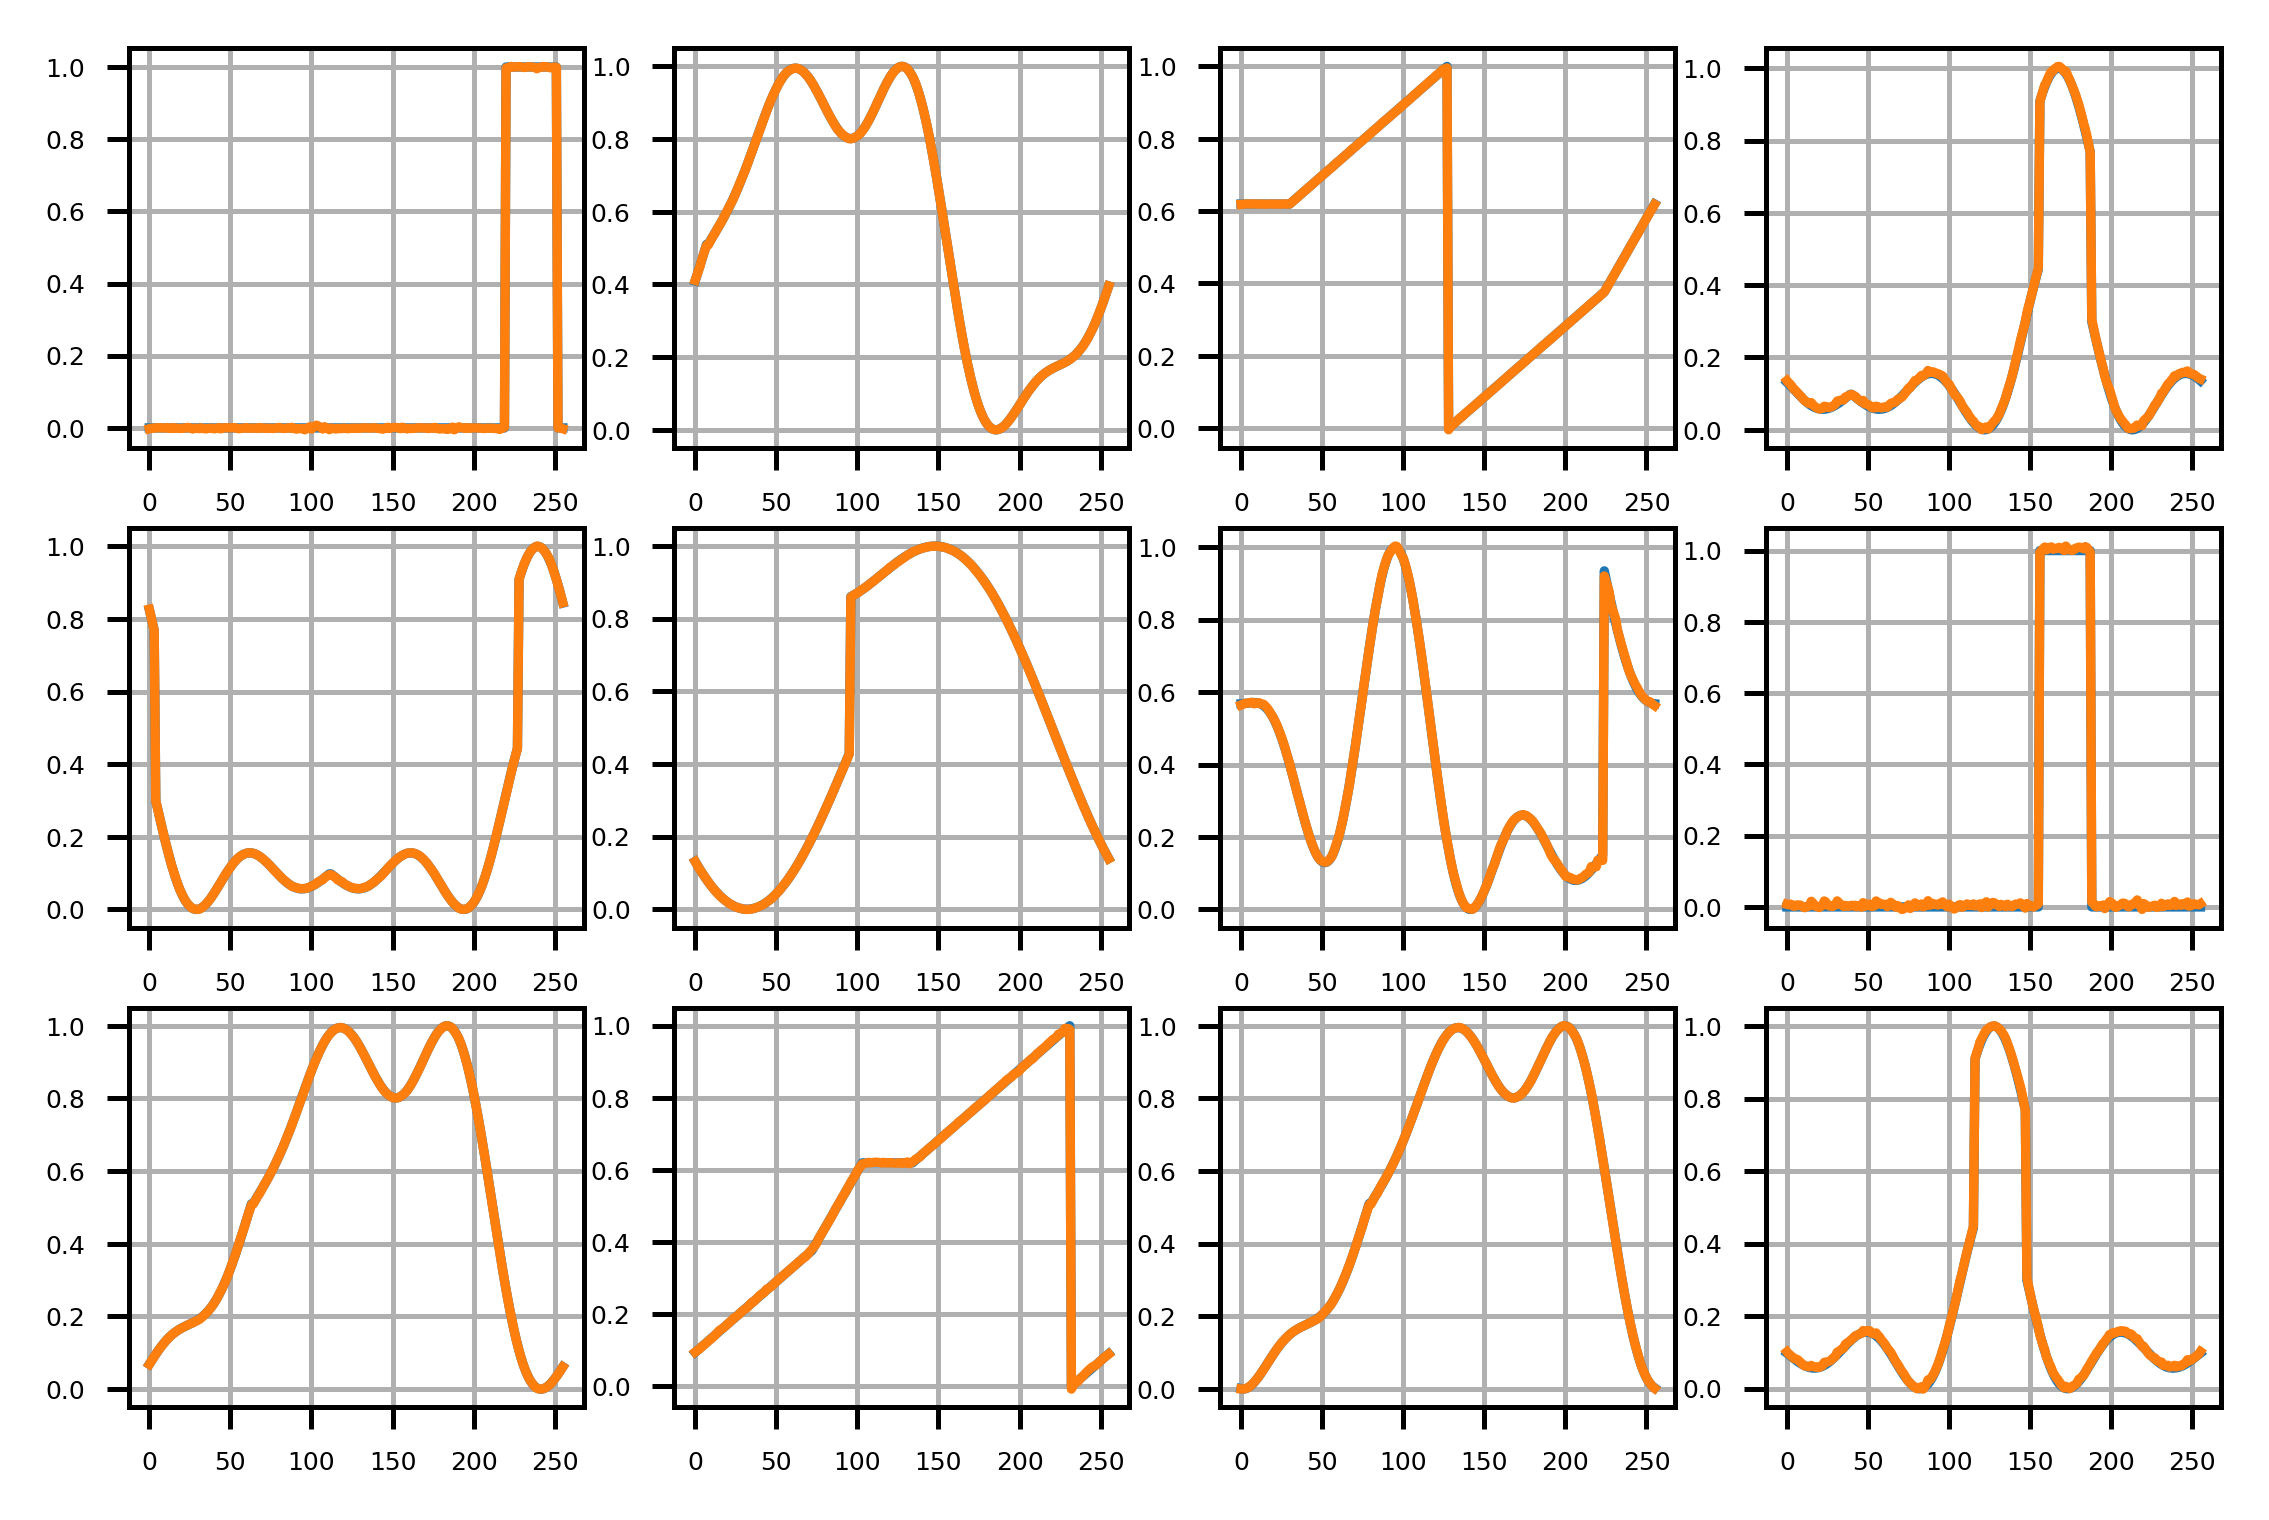

In [14]:
# Evaluate the test set
pred = model.predict(fft_signals_test_split)

fig, ax = plt.subplots(nrows=3, ncols=4,figsize = (6,4), dpi = 450)
counter = 0
for row in ax:
    for col in row:
        col.plot(signals_test[counter])
        col.plot(pred[counter])
        col.grid()
        counter+=1
plt.show()

## Absolute Error

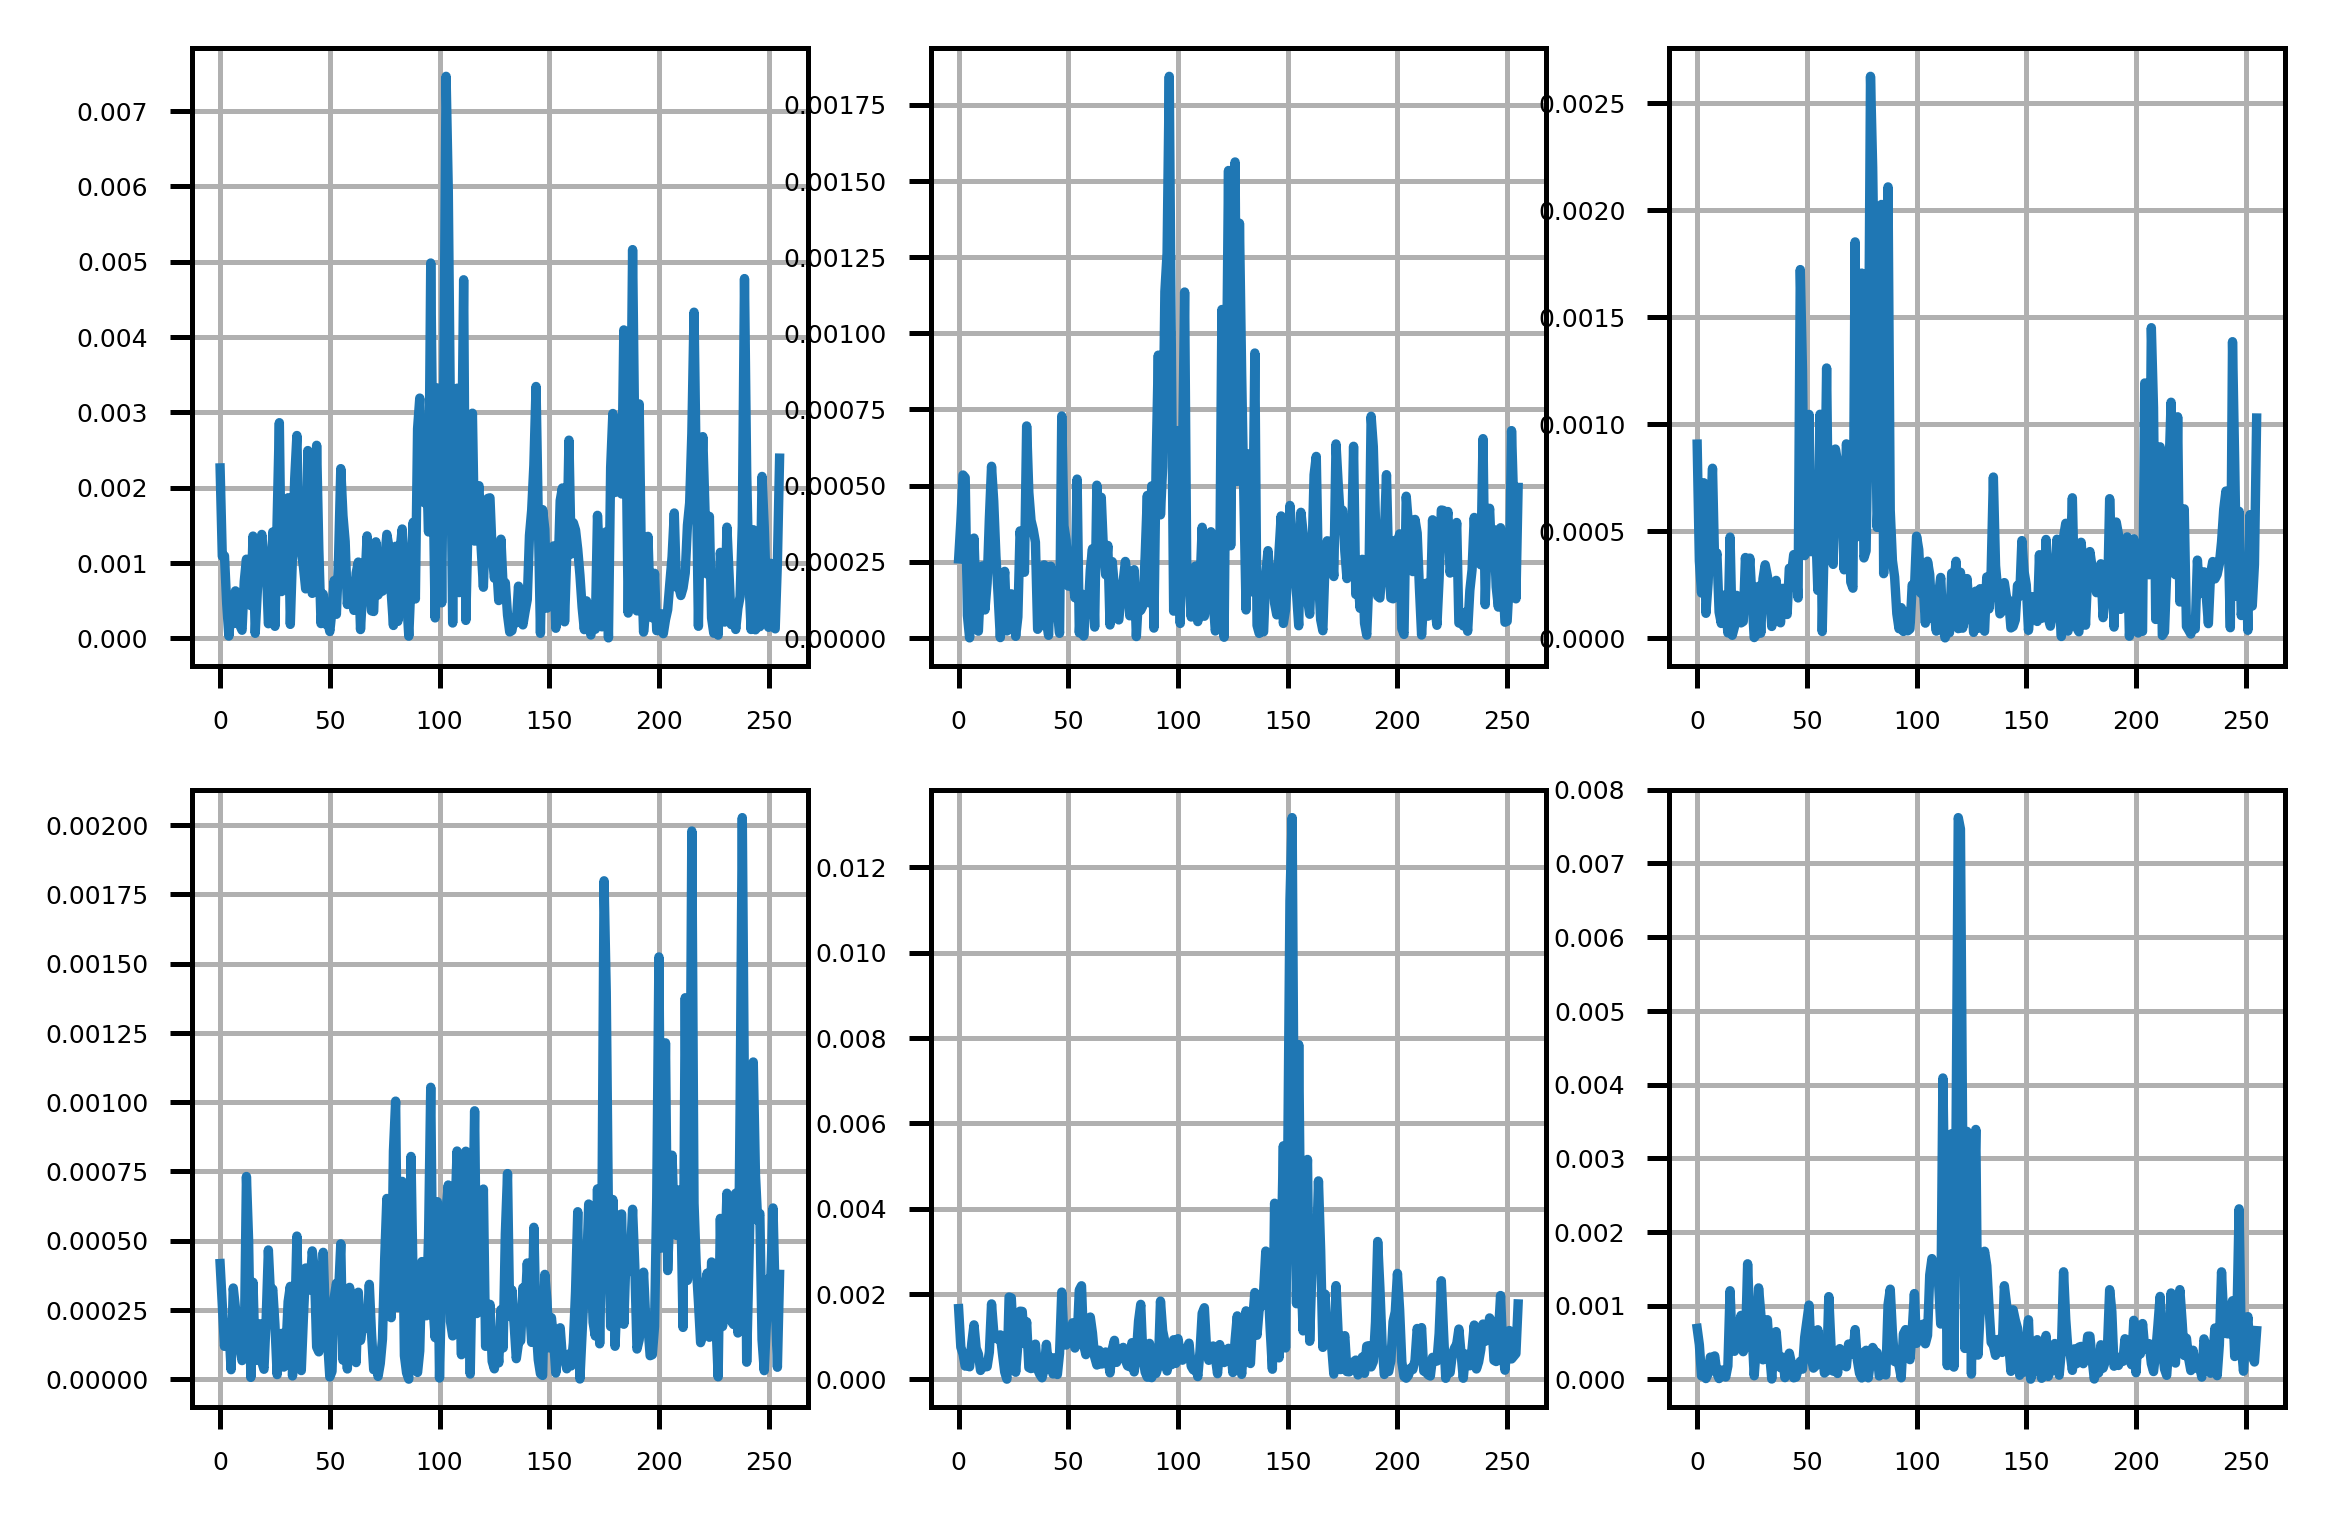

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=3,figsize = (6,4), dpi = 450)
counter = 0
for row in ax:
    for col in row:
        col.plot(np.abs(signals_test[counter]-pred[counter,:256]))
        col.grid()
        counter+=5
plt.show()